## Imports

In [118]:
#import copy
import json
import math
#import pprint
import random
#import scipy
import sklearn
#import statistics
import matplotlib.pyplot as plt
import numpy
import random
from scipy.stats import beta, fit, ecdf
from scipy.stats.mstats import gmean
from scipy.optimize import least_squares
from scipy.integrate import quad
from scipy.special import spence
import scipy.special as special
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score
import datetime
from IPython.display import display, Markdown, Latex

## Data loading and preprocessing

In [2]:
ranked_data_path = f"export.json"
ranked_data_file = open(ranked_data_path,encoding="utf-8")
ranked_data = json.load(ranked_data_file)

In [3]:
players = ranked_data["Players"]
maps = ranked_data["Maps"]
scores = ranked_data["Scores"]

In [4]:
min_score = 0.7
#filtered_scores = [score for score in scores if score["Accuracy"] > min_score and score["Accuracy"] < 1.0 and score["Modifiers"] == ""]
filtered_scores = [score for score in scores if score["Accuracy"] > min_score and score["Modifiers"] == ""]
print(len(scores))
print(len(filtered_scores))
print(len(filtered_scores)/len(scores))

3058785
2656448
0.8684650931660773


In [5]:
players_by_id = {player["Id"] : player for player in players}
maps_by_id = {bmap["Id"] : bmap for bmap in maps}
print(len(players_by_id.keys()))
print(len(maps_by_id.keys()))

107887
3635


### Calculating the gold standard for each map and adjusting scores with respect to that standard

In [6]:
# I don't like this, but for some reason the estimator does not allow values of exactly 1...
#gold_standard_multiplier = 0.9999

for map_id in maps_by_id:
    maps_by_id[map_id]["gold_standard"] = 0

for score in filtered_scores:
    map_id = score["LeaderboardId"]
    accuracy = score["Accuracy"]

    if accuracy > maps_by_id[map_id]["gold_standard"]:
        maps_by_id[map_id]["gold_standard"] = accuracy

#for score in filtered_scores:
#    map_id = score["LeaderboardId"]
#    accuracy = score["Accuracy"]

#    accuracy_wrt_gold = accuracy/maps_by_id[map_id]["gold_standard"]

#    score["accuracy_wrt_gold"] = accuracy_wrt_gold*gold_standard_multiplier    

In [7]:
scores_by_player_id = {}
scores_by_map_id = {}
score_data_by_map_id = {}

def add_score(score):
    player_id = score["PlayerId"]
    map_id = score["LeaderboardId"]
    
    player_map = scores_by_player_id.get(player_id,{})
    player_map[map_id] = score
    
    scores_by_player_id[player_id] = player_map    


    
    map_map = scores_by_map_id.get(map_id,{})
    map_map[player_id] = score
    
    scores_by_map_id[map_id] = map_map   


    
    score_data = score_data_by_map_id.get(map_id,[])

    score_data.append(score["Accuracy"])
    
    # Note that from now on we use the accuracy with respect to gold standard as data.
    # Therefore, when we want to go back to the actual score, we need to multiply by the gold standard or go to the original data.
    #score_data.append(score["accuracy_wrt_gold"])    

    score_data_by_map_id[map_id] = score_data

for score in filtered_scores:
    add_score(score)

for map_id in score_data_by_map_id:
    score_data = score_data_by_map_id[map_id]
    score_data.sort()
    score_data_by_map_id[map_id] = numpy.array(score_data)

## Fitting a map's scores to a beta distribution

In [ ]:
min_alpha = 1.01
min_beta = 1.01
min_multiplier=0.25
max_alpha = 50
max_beta = 25
max_multiplier=100

In [ ]:
def fit_scores_beta(scores):    
    # (a, b, loc, scale) = beta.fit(scores, bounds=[[min_alpha,max_alpha],[min_beta,max_beta]],floc=0, fscale=1)
    result = fit(beta, scores, bounds=[[min_alpha,max_alpha],[min_beta,max_beta]])
    
    (a, b, loc, scale) = result.params
    return (a,b)

beta_parameters_per_map = {}

n_maps = 0
for map_id,scores in score_data_by_map_id.items():
    n_maps = n_maps+1
    if n_maps % 100 == 0:
        print(f"{n_maps} maps fit")
        
    beta_parameters_per_map[map_id] = fit_scores_beta(scores)

In [ ]:
# Using least squares

# Some help from ChatGPT used here (adapted)
def residuals(params, scores):   
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b, max_score_mult = params    
    model_cdf = beta.cdf(rscore(scores,max_score_mult=max_score_mult), a, b)
    return model_cdf - empirical_cdf

def fit_scores_beta_least_squares(scores, initial_params):
    residuals_lambda = lambda params:residuals(params,scores)
    
    result = least_squares(residuals_lambda, initial_params, bounds=([min_alpha,min_beta,1/max_max_score],[max_alpha,max_beta,1/min_max_score]))
    
    return result.x

#least_squares_beta_parameters_per_map = {}

#n_maps = 0
#for map_id,scores in score_data_by_map_id.items():
    #(a,b) = beta_parameters_per_map[map_id]
    #initial_params = (a,b,hidden_max_score_mult)

    #n_maps = n_maps+1
    #if n_maps % 100 == 0:
    #    print(f"{n_maps} maps fit")

    #least_squares_beta_parameters_per_map[map_id] = fit_scores_beta_least_squares(scores, initial_params)

# Cheating, but these are really just initial values...
least_squares_beta_parameters_per_map = {map_id: (a,b,1) for map_id, (a,b) in beta_parameters_per_map.items()}

## Fitting the map's distribution through interpolation

In [8]:
# This is an absolutely monotonic linear interpolation.
# The way it works is the following:
# 1. Start at (0,0). Has an interpolation value for the next point (x1,y1), where the value stored s1 = y1. (The xi are predefined).
# 2. This defines a first derivative between these two points of y1/x1, so the next point has to be at that slope or higher.
#    That is, at least (x2, y1 + (y1/x1 * (x2-x1))). Instead of storing y2, we store the difference on the slope from y1/x1.
#    This allows the optimization algorithm to have a lower boundary of 0 for this value.
#    As a result, for stored value s2, the next point will be (x2, y1 + ((y1/x1 + s2) * (x2-x1))).
#    In other words, s2 indicates how much the first derivative increases.
# 3. For the fourth point, we do the same but with the second derivative. Let's spell it out.
#    The second derivative between the first three points is the difference between the first derivative at (x1,y1) -> y1/x1,
#    and the first derivative at (x2,y1 + ((y1/x1 + s2) * (x2-x1))) -> y1/x1 + s2. The difference is thus s2, divided by (x2 - x1).
#    Therefore, the fourth point has to have at least this second derivative from the last one. That is, the point will be
#    (x3, y2 + ((y1/x1 + s2 + s2/(x2-x1) * (x3-x2))*(x3-x2))). But the second derivative (s2/(x2-x1)) can be increased a bit more,
#    and this will be the third stored value s3. So the final fourth point will be:
#    (x3, y2 + ((y1/x1 + s2 + (s2/(x2-x1) + s3) * (x3-x2))*(x3-x2))).
# 4. And subsequently for each point, with as many derivatives as can be measured up to that point.
# This function generates the set of y values for the interpolation from the set of s values. The length of both lists has to be the same.
# We can optimize the s values and use this function to generate the interpolation.
def linear_interpolation_from_absolutely_monotonic(interpolation_xx, interpolation_ss, segment_size=1):
    n = len(interpolation_xx)
    
    xx = []
    
    # This stores not just the y values, but also the derivatives.
    # The first element (0) is a list with 1 element, just the y value (0-th derivative).
    # The second element (1) is a list with 2 eleemnts, the y value (0-th derivative) and the first derivative.
    # And so yyy[a][b] is the b-th derivative on the the a-th point, for b <= a, with all others presumed 0.
    yyy = []

    # First point, (0,0)
    cur_x = 0
    cur_yy = [0]
    
    xx.append(cur_x)
    yyy.append(cur_yy)

    for i in range(n):
        last_x = cur_x
        cur_x = interpolation_xx[i]
        cur_s = interpolation_ss[i]
        cur_diff = (cur_x - last_x)/segment_size
        cur_yy = cur_yy.copy()

        # Add the new derivative        
        cur_yy.append(cur_s)        
        
        # Cascade back to the other interpolation values.
        for j in range(i+1):
            cur_derivative = cur_yy[-1-j]
            cur_modified_y = cur_yy[-1-j-1]

            cur_modified_y += cur_derivative*cur_diff

            cur_yy[-1-j-1] = cur_modified_y

        xx.append(cur_x)
        yyy.append(cur_yy)

    # We return the interpolated xx's and yy's, but also the list of derivatives if the user wants to use them.
    yy = [yys[0] for yys in yyy]
    return (xx,yy,yyy)

# Each subsequent value is exponentiated to the nth power. This helps maintain relative scale of the coefficients.
def linear_interpolation_from_absolutely_monotonic_powers(interpolation_xx, interpolation_ss, **kwargs):
    n = len(interpolation_ss)
    interpolation_ss_powered = numpy.array([numpy.power(interpolation_ss[i],i+1) for i in range(n)])
    return linear_interpolation_from_absolutely_monotonic(interpolation_xx, interpolation_ss_powered, **kwargs)
    
# Uses the above but the interpolation_ss represent exponential exponents (on base e) of the derivative values.
# Useful for small scale segments (e.g. [0,1]) where derivatives take a lot to catch up.
def linear_interpolation_from_absolutely_monotonic_exp(interpolation_xx, interpolation_ss, **kwargs):
    return linear_interpolation_from_absolutely_monotonic(interpolation_xx, numpy.exp(interpolation_ss), **kwargs)

# Tower of exponentials
def linear_interpolation_from_absolutely_monotonic_nexp(interpolation_xx, interpolation_ss, n, **kwargs):
    if n == 0:
        return linear_interpolation_from_absolutely_monotonic(interpolation_xx, interpolation_ss, **kwargs)
    else:
        return linear_interpolation_from_absolutely_monotonic_nexp(interpolation_xx, numpy.exp(interpolation_ss), n-1, **kwargs)

# The ss values are the cumulative sum of what's input
def linear_interpolation_from_absolutely_monotonic_cumsum(interpolation_xx, interpolation_ss, **kwargs):
    return linear_interpolation_from_absolutely_monotonic(interpolation_xx, numpy.cumsum(interpolation_ss), **kwargs)

# The ss values are the cumulative sum of what's input, and then these are exponents.
def linear_interpolation_from_absolutely_monotonic_exp_cumsum(interpolation_xx, interpolation_ss, **kwargs):
    return linear_interpolation_from_absolutely_monotonic_exp(interpolation_xx, numpy.cumsum(interpolation_ss), **kwargs)

# Normalized to the size of the segments as many times as what derivative it is.
def linear_interpolation_from_absolutely_monotonic_normalized(interpolation_xx, interpolation_ss, **kwargs):
    segment_sizes_cum = numpy.cumprod(interpolation_xx-(numpy.append(0,interpolation_xx[:-1])))
    return linear_interpolation_from_absolutely_monotonic(interpolation_xx, interpolation_ss/segment_sizes_cum, **kwargs)

def linear_interpolation_from_absolutely_monotonic_normalized_exp(interpolation_xx, interpolation_ss, **kwargs):
    return linear_interpolation_from_absolutely_monotonic_normalized(interpolation_xx, numpy.exp(interpolation_ss), **kwargs)

# The ss values here always affect the direct y values, rather than the derivatives; and the derivatives are recalculated based on these.
# This makes the scaling across different ss values much more closely related in absolute terms.
def linear_interpolation_from_absolutely_monotonic_direct(interpolation_xx, interpolation_ss, segment_size=1):
    n = len(interpolation_xx)
    
    xx = []
    
    # This stores not just the y values, but also the derivatives.
    # The first element (0) is a list with 1 element, just the y value (0-th derivative).
    # The second element (1) is a list with 2 eleemnts, the y value (0-th derivative) and the first derivative.
    # And so yyy[a][b] is the b-th derivative on the the a-th point, for b <= a, with all others presumed 0.
    yyy = []

    # First point, (0,0)
    cur_x = 0
    cur_yy = [0]
    
    xx.append(cur_x)
    yyy.append(cur_yy)

    for i in range(n):
        last_x = cur_x
        cur_x = interpolation_xx[i]
        cur_s = interpolation_ss[i]
        cur_diff = (cur_x - last_x)/segment_size
        cur_yy = cur_yy.copy()

        # Add the new derivative, initially as 0.        
        cur_yy.append(0)        
        
        # Cascade back to the other interpolation values, this applies the previous derivatives to this point.
        for j in range(i+1):
            cur_derivative = cur_yy[-1-j]
            cur_modified_y = cur_yy[-1-j-1]

            cur_modified_y += cur_derivative*cur_diff

            cur_yy[-1-j-1] = cur_modified_y

        # Now add the ss value
        cur_yy[0] = cur_yy[0] + cur_s
        cur_modification = cur_s
        
        # And cascade upwards to each derivative.
        for j in range(i+1):
            cur_modification = cur_modification / cur_diff
            
            cur_modified_y = cur_yy[j+1]
            cur_modified_y += cur_modification

            cur_yy[j+1] = cur_modified_y
            
        xx.append(cur_x)
        yyy.append(cur_yy)

    # We return the interpolated xx's and yy's, but also the list of derivatives if the user wants to use them.
    yy = [yys[0] for yys in yyy]
    return (xx,yy,yyy)

In [9]:
def show_linear_interpolation(xx, yy):
    plt.plot(xx,yy,"c",marker="x",label="Interpolation")
    limits_xx,limits_yy = ([xx[0],xx[-1]],[yy[0],yy[-1]])
    plt.plot(limits_xx,limits_yy,"r",label="Direct line")
    
    plt.title(f"Linear interpolation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [10]:
min_segment_size = 0.01
max_segment_size = 1
default_segment_size = 0.1
min_multiplier = 0.25
max_multiplier = 5
default_multiplier = 1
min_nudge = 0
max_nudge = 100
default_nudge = 1
# Always 0 at 0.
interpolation_scores = numpy.array([0.7,0.8,0.85,0.9,0.93,0.95,0.97,0.98,0.99,1])

In [11]:
def pp_curve_absolutely_monotonic_interp(x, params):
    multiplier = params[0]
    nudges = params[1:]
    
    (xx,yy,yyy) = linear_interpolation_from_absolutely_monotonic_direct(interpolation_scores, nudges)
    xx = numpy.array(xx)
    
    yy = multiplier*numpy.divide(numpy.array(yy),yy[-1])

    return numpy.interp(x,xx,yy)

In [12]:
absolutely_monotonic_interp_parameters_per_map = {map_id: [default_multiplier] + [default_nudge for s in interpolation_scores] for map_id in maps_by_id}

## Generating a PP curve

In [13]:
# The way this is calculated is a bit inefficient right now, lots of redundant calculations
def pp_curve_integral(x, params):
    a, b, multiplier = params
    
    fun = lambda y: beta.cdf(y, a, b)      
    
    return multiplier*quad(fun, 0, x)[0]
    
# More efficient, for plotting it or for reusing variables
def plot_pp_curve_integral(xx, params):
    a, b, multiplier = params
    fun = lambda y: beta.cdf(y, a, b)

    mmax = quad(fun, 0, 1)[0]
    
    segments = numpy.array([quad(fun,s,e)[0] for s,e in zip(xx[:-1],xx[1:])])
        
    cumulative = numpy.cumsum(segments)
    # Renormalize to total, to correct for numerical errors in extreme cases.
    last = cumulative[-1]
    cumulative = cumulative*mmax/last
    cumulative = numpy.append(cumulative,mmax)    
    
    return multiplier*cumulative

# Should be a set of xx that is representative and a yy that corresponds to calling plot_pp_curve_integral on those xx.
def pp_curve_interp(x, xx, yy):
    result = numpy.interp(x,xx,yy)    
    return result

# Some help from ChatGPT here: https://chatgpt.com/share/685755df-db50-8010-90a2-31923049bfe7
# (I did check this seems correct in many different values, though, and a skim of the math checks out)
# A closed form of the integral that I can use to much more quickly calculate it.
def pp_curve_integral_closed(x, params):
    (a, b, multiplier) = params
    
    Ix_ab = beta.cdf(x,a,b)
    Ix_ap1b = beta.cdf(x,a + 1,b)
    B_ab = special.beta(a, b)
    B_ap1b = special.beta(a + 1, b)
    
    return multiplier*(x * Ix_ab - Ix_ap1b * B_ap1b / B_ab)

In [ ]:
def pp_curve_log(x, params):
    #a, b, gold_standard = params
    a, b, max_score_mult = params

    #r_gold_standard = numpy.log(log_over_one - beta.cdf(gold_standard, a, b))
    f = beta.cdf(rscore(x,max_score_mult=max_score_mult), a, b)

    #return numpy.log(log_over_one - f)/r_gold_standard
    #return -numpy.log(log_over_one - f)
    return -numpy.log(1 - f)

In [ ]:
def pp_curve_dilog(x, params):
    # a, b, gold_standard = params
    a, b, max_score_mult = params

    #r_gold_standard = spence(1 - beta.cdf(gold_standard, a, b))
    f = beta.cdf(rscore(x,max_score_mult=max_score_mult), a, b)

    #return spence(1 - f)/r_gold_standard
    #return spence(log_over_one - f)/r_gold_standard
    return spence(1 - f)

In [ ]:
exponential_base = 1000000
exponential_coefficient = 1/(exponential_base-1)

def pp_curve_exponential(x, params):
    a, b, multiplier = params

    skill = multiplier*beta.cdf(x, a, b)

    return pp_from_skill_exponential(skill)

def pp_from_skill_exponential(skill):
    return (numpy.power(exponential_base,skill)-1)*exponential_coefficient

In [ ]:
hyperexponential_base = 7
hyperexponential_coefficient = 1/(numpy.power(hyperexponential_base,hyperexponential_base)-hyperexponential_base)

def pp_curve_hyperexponential(x, params):
    a, b, multiplier = params

    skill = multiplier*beta.cdf(x, a, b)

    return pp_from_skill_hyperexponential(skill)

def pp_from_skill_hyperexponential(skill):
    return (numpy.power(hyperexponential_base,numpy.power(hyperexponential_base,skill))-hyperexponential_base)*hyperexponential_coefficient

In [ ]:
exponential_base = 100
exponential_coefficient = 1/(exponential_base-1)

def pp_curve_integral_exponential(x, params):
    integral = pp_curve_integral_closed(x, params)

    return (numpy.power(exponential_base,integral)-1)*exponential_coefficient

## Birating algorithm to estimate parameters by mutual iteration

In [14]:
class BiRating:
    """No description yet"""
    
    def __init__(self,
                 anodes_params,bnodes_params,
                 afun,bfun,
                 anorm, bnorm,
                 metrics_fun,
                 metrics_halt_condition,
                 max_iter=10,
                 iter_fun=None,
                 metrics_each_iteration=True,
                 debug=False):
        """
        anodes_params and bnodes_params must be dictionaries with the node identifiers as keys
        and initial parameters as values.
                
        afun and bfun must be functions taking an identifier of the corresponding node type, the prior parameters
        for the corresponding node, and the dictionary of all parameters for the other node type,
        and returns the corresponding parameters for the node that is calculated from them.

        anorm and bnorm are functions called after the a and b cycle respectively to normalize the values after having calculated all of them.
        These receives the sets of weights of their type, and receives the resulting set of weights (that can be the same).
        
        metrics_fun receives the two anodes_params and bnodes_params dictionaries with the most recent values
        and generates metrics for the current result, in whatever format

        metrics_halt_condition receives the result of metrics_fun of this iteration and the last, and returns True or False indicating
        whether the algorithm should continue (True means continue).

        iter_fun is an optional callback function that is called after calculating metrics after each iteration. It receives the
        iteration number, the node parameters, and the last calculated metrics.
        """
        self.anodes_params = anodes_params.copy()
        self.bnodes_params = bnodes_params.copy()
                
        self.afun = afun
        self.bfun = bfun

        self.anorm = anorm
        self.bnorm = bnorm

        self.metrics_fun = metrics_fun
        self.metrics_halt_condition = metrics_halt_condition    
        self.metrics_each_iteration = metrics_each_iteration
        
        self.iter = 0
        self.max_iter = max_iter              

        self.iter_fun = iter_fun      

        self.metrics = []

        self.debug_on = debug

    def debug(self,text):
        if self.debug_on:
            print(text)
        
    def calculate_metrics(self):
        return self.metrics_fun(self.anodes_params,self.bnodes_params)

    def metrics_iteration(self):
        if self.metrics_each_iteration:
            metrics = self.calculate_metrics()
            if not self.iter_fun is None:
                self.iter_fun(self.iter,self.anodes_params,self.bnodes_params,metrics)
    
            if len(self.metrics) > 0:
                continue_flag = self.metrics_halt_condition(metrics, self.metrics[-1])    
    
                self.metrics.append(metrics)
        
                return continue_flag
            else:
                self.metrics.append(metrics)
    
                return True
        else:
            return True
   
    def acycle(self):
        anodes = 0
        for anode_id in self.anodes_params:
            anodes = anodes + 1
            if anodes % 500 == 0:
                self.debug(f"{anodes} A nodes processed")
            self.anode_process(anode_id)

        self.anodes_params = self.anorm(self.anodes_params)
    
    def anode_process(self,anode_id):        
        self.anodes_params[anode_id] = self.afun(anode_id,self.anodes_params[anode_id],self.bnodes_params)
    
    def bcycle(self):
        bnodes = 0
        for bnode_id in self.bnodes_params:
            bnodes = bnodes + 1
            if bnodes % 5000 == 0:
                self.debug(f"{bnodes} B nodes processed")
            self.bnode_process(bnode_id)

        self.bnodes_params = self.bnorm(self.bnodes_params)
    
    def bnode_process(self,bnode_id):                
        self.bnodes_params[bnode_id] = self.bfun(bnode_id,self.bnodes_params[bnode_id],self.anodes_params)
    
    def iterate(self):
        self.debug("B cycle starting")
        self.bcycle()
        self.debug("A cycle starting")
        self.acycle()
        
        self.iter += 1

        self.debug("Metrics iteration")
        return self.metrics_iteration()
        
    def run(self):    
        if not self.metrics_iteration():
            return (self.anodes_params,self.bnodes_params)   
        
        while (self.iter <= self.max_iter and self.iterate()):
            self.debug(f"{self.iter} iterations complete")
            pass
                
        return (self.anodes_params,self.bnodes_params)   
    

In [17]:
class BetaSaberBiRating(BiRating):
    def __init__(self,
                 map_data_by_id,
                 score_data_by_map_id_player_id,
                 score_data_by_player_id_map_id,
                 beta_params_per_map_id,
                 skill_per_player_id,
                 aggregation_player_skill_fun = aggregation_pp_topscores,
                 max_scores_weight=50,                 
                 score_weight_factor=0.965,
                 iter_fun = None,
                 metrics_each_iteration=True,
                 debug = False,
                 r2_each_iteration = True,
                 **kwargs):
        """
        map_data_by_id is the master dictionary of map data. Only some things are used.

        No player data is required.

        score_data_by_map_id_player_id and score_data_by_player_id_map_id are two doubly indexed dictionaries with the same data in opposite indexing orders.
        
        beta_params_per_map_id is a dictionary with map ids as keys and tuples of (a,b,max_score_mult) parameters as values

        skill_per_player_id is a dictionary with player ids as keys and pairs (skill,weight) of estimations of skill (value between 0 and 1, a quantile),
            and weight (proportion of up to 50 maps the player has played) as values.
        """
        
        self.map_data_by_id = map_data_by_id
        self.score_data_by_map_id_player_id = score_data_by_map_id_player_id
        self.score_data_by_player_id_map_id = score_data_by_player_id_map_id
        self.aggregation_player_skill_fun = aggregation_player_skill_fun
        self.max_scores_weight = max_scores_weight
        self.score_weight_factor = score_weight_factor
        self.score_weight_by_map_id_player_id = {map_id: {player_id: 1 for player_id in by_player.keys()} for map_id, by_player in score_data_by_map_id_player_id.items()}
        self.bins_by_map_id = {map_id: (numpy.array([]),numpy.array([]),numpy.array([])) for map_id in map_data_by_id}
        self.pp_curve_by_map_id = {}
                
        anodes_params = beta_params_per_map_id
        bnodes_params = skill_per_player_id
        
        afun = self.map_fun
        bfun = self.player_fun

        anorm = self.map_norm
        bnorm = self.player_norm

        metrics_fun = self.betasaber_metrics
        metrics_halt_condition = self.halt_condition

        self.r2_each_iteration = r2_each_iteration

        super().__init__(anodes_params, bnodes_params, afun, bfun, anorm, bnorm, metrics_fun, metrics_halt_condition, iter_fun = iter_fun, debug = debug, metrics_each_iteration = metrics_each_iteration, **kwargs)

        # This is not necessarily standard, it's to generate the integrals of the maps.
        self.map_norm(anodes_params)
        
    def player_fun(self, player_id, player_skill, map_params_by_id):
        # We could have some momentum on player skill here if we wanted to.        

        estimations = [(map_id,self.get_player_estimation(score_data["Accuracy"], map_id, map_params_by_id[map_id]))
                       for map_id,score_data in self.score_data_by_player_id_map_id[player_id].items()]

        estimations.sort(key=self.player_estimation_sort_key, reverse=True)

        estimation_values = []
        #weight = 1        
        for (map_id,estimation) in estimations:
            estimation_values.append(estimation)
            #self.score_weight_by_map_id_player_id[map_id][player_id] = weight
            #weight = weight * self.score_weight_factor
        
        return (self.aggregation_player_skill_fun(estimation_values), math.sqrt(min(self.max_scores_weight,len(estimation_values))/self.max_scores_weight))

    def player_estimation_sort_key(self, estimation):
        return estimation[1]

    # Should be increasing with respect to the real estimation, as it is used to choose the top 50 maps.
    def get_player_estimation(self, score, map_id, map_params):                
        (xx, yy) = self.pp_curve_by_map_id[map_id]
        return pp_curve_interp(score, xx, yy)

    def player_norm(self, player_params):
        return player_norm_proportional(player_params)

    def get_pp_weight(self, accuracy, map_params, gold_standard):
        return pp_curve_absolutely_monotonic_interp(accuracy, map_params)

    def map_fun(self, map_id, map_params, player_params_by_id):
        scores = []
        skills = []
        weights = []

        #self.debug(f"Map {map_id} before: {map_params}")
        for player_id,score_data in self.score_data_by_map_id_player_id[map_id].items():
            accuracy = score_data["Accuracy"]
            (skill,player_weight) = player_params_by_id[player_id]
            #score_weight = self.score_weight_by_map_id_player_id[map_id][player_id]
            scores.append(accuracy)
            skills.append(skill)
            #weights.append(player_weight * score_weight)
            weights.append(player_weight)

        # Sort by scores, necessary for the optimization to work
        (scores,skills,weights) = zip(*sorted(zip(scores, skills, weights)))
        
        scores = numpy.array(scores)
        skills = numpy.array(skills)
        weights = numpy.array(weights)
        #self.debug(f"{len(scores)} scores sent to least squares")
        (binned_scores,binned_skills,binned_weights) = generate_bins_score_skills(scores,skills,weights)
        self.bins_by_map_id[map_id] = (binned_scores,binned_skills,binned_weights)
        result = fit_scores_absolutely_monotonic_interp_least_squares(binned_scores, binned_skills, binned_weights, map_params)
        #self.debug(f"Map {map_id} after: {result}")
        return result

    def map_norm(self, map_params):        
        nmaps = 0
        for map_id,params in map_params.items():
            nmaps = nmaps + 1
            if nmaps % 500 == 0:
                self.debug(f"{nmaps} map plots precalculated")
            
            self.pp_curve_by_map_id[map_id] = generate_pp_curve_absolutely_monotonic_interp(params)
            
        return map_params
        
    def betasaber_metrics(self, map_params_by_id, player_params_by_id):
        self.debug("Beginning to calculate metrics")
        
        # Modifiable parameters
        quantiles = numpy.array([0, 0.25, 0.5, 0.75, 0.9, 1])
        score_thresholds = numpy.array([0.7, 0.8, 0.85, 0.9, 0.93, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 1])

        # Calculations
        map_metrics_by_id = {}
        map_r2_array = []

        highest_min_threshold_map_id = None
        highest_min_threshold = 0
        highest_100_threshold_map_id = None
        highest_100_threshold = 0
        lowest_100_threshold_map_id = None
        lowest_100_threshold = 99999

        debug_each_map = False        
        n_maps = 0
        
        for map_id,score_dataset in self.score_data_by_map_id_player_id.items():
            n_maps = n_maps + 1
            if n_maps % 50 == 0:
                self.debug(f"{n_maps} measured")
            
            if debug_each_map:
                self.debug(f"Map id: {map_id}")
            
            map_metrics = {}
            
            map_params = map_params_by_id[map_id]
            gold_standard = self.map_data_by_id[map_id]["gold_standard"]
            map_metrics["gold_standard"] = gold_standard

            # R2
            if self.r2_each_iteration:
                scores = []
                skills = []
                
                for player_id,score_data in score_dataset.items():
                    accuracy = score_data["Accuracy"]
                    (skill,weight) = player_params_by_id[player_id]
                    scores.append(accuracy)
                    skills.append(skill)

                scores = numpy.array(scores)
                skills = numpy.array(skills)
                
                r2 = r_squared_with_skill(map_params, scores, skills)
                if debug_each_map:
                    self.debug(f"R2 squared: {r2}")
                map_r2_array.append(r2)
                map_metrics["r2"] = r2

            # Player skill thresholds
            skill_thresholds = [self.get_player_estimation(threshold, map_params) for threshold in score_thresholds]
            map_metrics["skill_thresholds"] = skill_thresholds

            # PP weight thresholds
            pp_thresholds = [self.get_pp_weight(threshold, map_params, gold_standard) for threshold in score_thresholds]
            map_metrics["pp_thresholds"] = pp_thresholds

            min_threshold = pp_thresholds[0]
            f100_threshold = pp_thresholds[-1]

            if debug_each_map:
                self.debug(f"Min threshold: {min_threshold}")
                self.debug(f"f100_threshold: {f100_threshold}")

            if min_threshold > highest_min_threshold:
                highest_min_threshold = min_threshold
                highest_min_threshold_map_id = map_id

            if f100_threshold > highest_100_threshold:
                highest_100_threshold = f100_threshold
                highest_100_threshold_map_id = map_id

            if f100_threshold < lowest_100_threshold:
                lowest_100_threshold = f100_threshold
                lowest_100_threshold_map_id = map_id

            map_metrics_by_id[map_id] = map_metrics
        

        if self.r2_each_iteration:
            map_r2_array = numpy.array(map_r2_array)
            map_r2_quantiles = numpy.quantile(map_r2_array,quantiles)
        else:
            map_r2_quantiles = []
                
        #player_skill_array = numpy.array(list(player_params_by_id.values()))
        #player_skill_quantiles = numpy.quantile(player_skill_array,quantiles)

        metrics = {
            "map_metrics_by_id": map_metrics_by_id,
            "map_r2_quantiles": map_r2_quantiles,
            #"player_skill_quantiles": player_skill_quantiles,
            "highest_min_threshold_map_id": highest_min_threshold_map_id,
            "highest_min_threshold": highest_min_threshold,
            "highest_100_threshold_map_id": highest_100_threshold_map_id,
            "highest_100_threshold": highest_100_threshold,
            "lowest_100_threshold_map_id": lowest_100_threshold_map_id,
            "lowest_100_threshold": lowest_100_threshold
        }

        self.debug("Finalising metrics calculation")

        return metrics

    def halt_condition(self, metrics, previous_metrics):
        # For now we just do max iterations
        return True
            

In [16]:
# Helper functions that can be swapped more easily

# Exponential decaying average of skill estimations.
def aggregation_player_skill_decaying(player_skill_estimations, factor = 0.965, max_n = 50):    
    player_skill_estimations.sort(reverse=True)
    
    result = 0
    current_factor = 1
    # Finite geometric series
    divisor = current_factor*(1-pow(factor,max_n))/(1-factor)
    n = 1
    for estimation in player_skill_estimations:
        n = n + 1
        if n > max_n:
            break
        result = result + current_factor * estimation
        current_factor = current_factor * factor

    return result/divisor    

def aggregation_player_skill_average(player_skill_estimations):
    return numpy.average(player_skill_estimations)

def aggregation_topscores(player_skill_estimations,perc=0.5,default_value=0.5):
    #player_skill_estimations.sort()
    l = len(player_skill_estimations)
    n = math.ceil(l*perc)
    
    if n == 0:
        return default_value
    else:
        return numpy.average(player_skill_estimations[l-n:])    

def aggregation_pp_topscores(player_skill_estimations,n=50,default_value=0.5):
    l = len(player_skill_estimations)
    n = min(n,l)
    
    if n == 0:
        return default_value
    else:
        return numpy.average(player_skill_estimations[:n])    
        
# scores and skills should be in the same order
# Note that weights should be square rooted already!!
def residuals_with_skill(params, scores, skills, weights):   
    # Component 1 - How well the skills are explained.
    empirical_cdf = skills
    
    a, b, max_score_mult = params
    model_cdf = beta.cdf(rscore(scores,max_score_mult=max_score_mult), a, b)    
    skill_diff = model_cdf - empirical_cdf

    # Component 2 (regularization) - Likelihood of the observations
    #likelihoods = beta.pdf(rscore(scores,max_score_mult=max_score_mult), a, b)    

    # Combine them in a multiplicative way so that the scale for each of them does not overwhelm the other.
    # When comparing different residuals, as long as their proportions are comparable, it will work.
    # Higher likelihood is better, so for the residual we divide by the likelihood.
    # There's a lot of doubts about whether this will work or not.
    #unweighted_residuals = skill_diff/likelihoods
    unweighted_residuals = skill_diff
    
    return numpy.dot(weights,unweighted_residuals)

def fit_scores_beta_least_squares_with_skill(scores, skills, weights, initial_params):
    residuals_lambda = lambda params:residuals_with_skill(params,scores,skills,weights)
    
    result = least_squares(residuals_lambda, initial_params, bounds=([min_alpha,min_beta,1/max_max_score],[max_alpha,max_beta,1/min_max_score]))

    #print(f"THE RESULT HERE IS {result}")
    #print(f"result.x = {result.x}")
    return result.x

# R squared - For one map.
# NOTE THAT WE DO NOT USE WEIGHTS HERE JUST NOW
def r_squared_with_skill(params, scores, skills):    
    empirical_cdf = skills
    
    a, b, max_score_mult = params
    model_cdf = beta.cdf(rscore(scores,max_score_mult=max_score_mult), a, b)

    return r2_score(empirical_cdf, model_cdf)

# These values are extremely sensitive and can lead to infinite loops. They also depend on min_score, so make sure to readjust if that is adjusted.
initial_bin_width = 0.01
bin_width_multiplier = 0.97
# Please ensure data is sorted beforehand (by scores)!!
def generate_bins_score_skills(scores, skills, weights):
    result_scores = []
    result_skills = []
    result_weights = []

    n = len(scores)
    i = 0
    bin_width = initial_bin_width
    cur_lower_score = min_score    
    while i < n:        
        cur_upper_score = cur_lower_score + bin_width

        cur_total_skill = 0
        cur_total_weight = 0

        while i < n and scores[i] < cur_upper_score:
            cur_total_skill += skills[i]*weights[i]
            cur_total_weight += weights[i]
            i += 1            

        if cur_total_weight > 0:
            result_scores.append((cur_lower_score+cur_upper_score)/2)            
            result_skills.append(cur_total_skill/cur_total_weight)
            # We make scores closer to 100% count more, on top of being more dense.
            # Arbitrary choice of weighting.
            # It's just a weighting so exactness isn't terribly necessary but we might want to revisit this.
            #cur_total_weight = cur_total_weight/(1.1-cur_lower_score)
            result_weights.append(cur_total_weight)                       

        bin_width *= bin_width_multiplier
        cur_lower_score = cur_upper_score

    return (numpy.array(result_scores),numpy.array(result_skills),numpy.array(result_weights))

# Please ensure data is sorted beforehand (by scores)!!
def residuals_range_with_skill(params, scores, skills, weights):    
    (integral_xx, integral_yy) = generate_pp_curve(params)

    model_pp = pp_curve_interp(scores,integral_xx,integral_yy)
    empirical_pp = skills
    
    return weights*(model_pp - empirical_pp)

def fit_scores_beta_least_squares_range_with_skill(scores, skills, weights, initial_params):        
    residuals_lambda = lambda params:residuals_range_with_skill(params,scores,skills,weights)
    
    result = least_squares(residuals_lambda, initial_params, bounds=([min_alpha,min_beta,min_multiplier],[max_alpha,max_beta,max_multiplier]))

    return result.x

kernel_sigma = 0.01
residual_step = 0.001
# https://stackoverflow.com/questions/24143320/gaussian-sum-filter-for-irregular-spaced-points
def kernel_smoothing_scores_skills(x_eval, scores, skills, weights):    
    
    delta_x = x_eval[:, None] - scores
    
    kernel_weights = numpy.exp(-delta_x*delta_x / (2*kernel_sigma*kernel_sigma)) / (numpy.sqrt(2*numpy.pi) * kernel_sigma)
    kernel_weights *= weights
    kernel_weights /= numpy.sum(kernel_weights, axis=1, keepdims=True)   
    
    y_eval = numpy.dot(kernel_weights, skills)
    
    return y_eval

#integral_plot_initial_width = 0.15
#integral_plot_width_multiplier = 0.87

#integral_plot_xx = []
#integral_plot_width = integral_plot_initial_width
#integral_plot_cur_lower_end = 0
#while integral_plot_cur_lower_end < 1:
    #integral_plot_cur_upper_end = integral_plot_cur_lower_end + integral_plot_width

    #integral_plot_xx.append(integral_plot_cur_lower_end)

    #integral_plot_width *= integral_plot_width_multiplier

    #integral_plot_cur_lower_end = integral_plot_cur_upper_end

#integral_plot_xx = numpy.array(integral_plot_xx)

integral_plot_xx = numpy.array([0,0.25,0.5,0.7,0.8,0.85,0.9,0.93,0.95,0.97,0.98,0.99,1])
def generate_pp_curve(params):    
    yy = pp_curve_integral_closed(integral_plot_xx, params)

    return (integral_plot_xx,yy)

def generate_pp_curve_absolutely_monotonic_interp(params):
    multiplier = params[0]
    nudges = params[1:]
    
    (xx,yy,yyy) = linear_interpolation_from_absolutely_monotonic_direct(interpolation_scores, nudges)
    xx = numpy.array(xx)
    
    yy = multiplier*numpy.divide(numpy.array(yy),yy[-1])

    return (xx,yy)

def player_norm_cdf(player_params):
    player_values = numpy.array([skill for (skill,weight) in list(player_params.values())])

    cdf_object = ecdf(player_values)
    cdf = cdf_object.cdf        

    result = {player_id: (cdf.evaluate(player_skill),weight) for (player_id,(player_skill,weight)) in player_params.items()}
    
    return result

def player_norm_proportional(player_params):
    player_values = numpy.array([skill for (skill,weight) in list(player_params.values())])

    max_skill = numpy.max(player_values)
    min_skill = numpy.min(player_values)
    diff = max_skill - min_skill

    result = {player_id: ((player_skill - min_skill)/diff,weight) for (player_id,(player_skill,weight)) in player_params.items()}
    
    return result

def residuals_absolutely_monotonic_interp(params, scores, skills, weights):    
    (xx, yy) = generate_pp_curve_absolutely_monotonic_interp(params)

    model_pp = pp_curve_interp(scores,xx,yy)
    empirical_pp = skills
    
    return weights*(model_pp - empirical_pp)

def fit_scores_absolutely_monotonic_interp_least_squares(scores, skills, weights, initial_params):        
    residuals_lambda = lambda params:residuals_absolutely_monotonic_interp(params,scores,skills,weights)
    
    result = least_squares(residuals_lambda, initial_params, bounds=([min_multiplier] + [min_nudge for s in interpolation_scores],[max_multiplier] + [max_nudge for s in interpolation_scores]))

    return result.x

## General metrics

In [ ]:
# R squared
def r_squared_beta(params, scores):
    # We presume the scores are sorted for performance!
    #scores.sort()
    
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b = params
    model_cdf = beta.cdf(rscore(scores), a, b)

    return r2_score(empirical_cdf, model_cdf)
    
# Quantiles
def quantiles_beta(params, scores, n_quantiles):    
    # We presume the scores are sorted for performance!
    #scores.sort()
    
    quantiles = numpy.arange(1, n_quantiles) / n_quantiles

    n = len(scores)    

    def empirical_quantile(quantile):
        return scores[math.floor(n*quantile)]

    a, b = params
    def model_quantile(quantile):
        return beta.ppf(quantile, a, b)        
        
    return {quantile:(empirical_quantile(quantile),model_quantile(quantile)) for quantile in quantiles}

n_quantiles = 10
beta_r_squared_values = {}
beta_quantile_values = {}
least_squares_beta_r_squared_values = {}
least_squares_beta_quantile_values = {}

for map_id,scores in score_data_by_map_id.items():
    params = beta_parameters_per_map[map_id]
    least_squares_params = least_squares_beta_parameters_per_map[map_id]
    
    beta_r_squared_values[map_id] = r_squared_beta(params,scores)
    beta_quantile_values[map_id] = quantiles_beta(params,scores,n_quantiles)
    least_squares_beta_r_squared_values[map_id] = r_squared_beta(least_squares_params,scores)
    least_squares_beta_quantile_values[map_id] = quantiles_beta(least_squares_params,scores,n_quantiles)

## Plots

In [ ]:
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_density_by_map_id(map_id, map_params_by_map_id = least_squares_beta_parameters_per_map, **kwargs):        
    #(mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb,max_score_mult) = map_params_by_map_id[map_id]
    
    scores = score_data_by_map_id[map_id]

    map_data = maps_by_id[map_id]

    show_map_density(map_data,scores,lsa,lsb,max_score_mult,**kwargs)

# The gold standard is presumed to be in map_data
def show_map_density(map_data, scores, a, b, max_score_mult, suffix = ""):
    n_scores = len(scores)
    gold_standard = map_data["gold_standard"]   
        
    #xx = numpy.linspace(min_score,1,n_scores)    
    xx = numpy.linspace(0,1,n_scores)    

    ls_fitted = lambda x:beta.pdf(rscore(x,max_score_mult=max_score_mult),a,b)    
    ls_fitted_values = ls_fitted(xx)
    max_density = numpy.max(ls_fitted_values)

    plt.hist(scores,bins=15,density=True,label="Real score distribution")
    plt.plot(xx,ls_fitted_values,"r",label="Least squares estimation")

    plt.vlines(gold_standard,0,max_density+1,colors="y",linestyles="dotted",label=f"Max. realistic score={gold_standard:.2f}")   

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Score density for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) {suffix}")
    plt.xlabel("Score percentage")
    plt.ylabel("Density")
    plt.yticks([])
    plt.xticks(x_ticks,labels=x_labels)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [ ]:
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_distribution_by_map_id(map_id, map_params_by_map_id = least_squares_beta_parameters_per_map, **kwargs):        
    #(mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb,max_score_mult) = map_params_by_map_id[map_id]
    
    scores = score_data_by_map_id[map_id]    

    map_data = maps_by_id[map_id]

    show_map_distribution(map_data,scores,lsa,lsb,max_score_mult, **kwargs)

# The gold standard is presumed to be in map_data
def show_map_distribution(map_data, scores, a, b,max_score_mult, suffix = ""):    
    n_scores = len(scores)
    gold_standard = map_data["gold_standard"]   
    
    ls_fitted = lambda x: beta.cdf(rscore(x,max_score_mult=max_score_mult),a,b)        
    
    xx = numpy.linspace(0,1,n_scores)
    yy = numpy.linspace(0,1,n_scores)      

    plt.plot(scores, yy, marker='.', linestyle='-',label="Real score distribution")    
    plt.plot(xx,ls_fitted(xx),"r",label="Least squares estimation")

    plt.vlines(gold_standard,0,1,colors="y",linestyles="dotted",label=f"Max. realistic score={gold_standard}:.2f")    
    
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks(x_ticks,labels=x_labels)

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Score distribution for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) {suffix}")
    plt.xlabel("Score percentage")
    plt.ylabel("Proportion of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [18]:
key_points = [0.75,0.9,0.97,1]
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

In [19]:
def show_map_pp_by_map_id(map_id, skills_by_player_id, map_params_by_map_id = absolutely_monotonic_interp_parameters_per_map, binned_distribution_by_map_id=None, interpolation_by_map_id=None, **kwargs):        
       
    scores = score_data_by_map_id[map_id]
    scores_with_players = scores_by_map_id[map_id]

    sort_func = lambda player_id: scores_with_players[player_id]["Accuracy"]
    sorted_player_ids = list(scores_with_players.keys())
    sorted_player_ids.sort(key=sort_func)
    skills = [skills_by_player_id[player_id][0] for player_id in sorted_player_ids]

    map_data = maps_by_id[map_id]

    if not binned_distribution_by_map_id is None:
        binned_distribution = binned_distribution_by_map_id[map_id]
    else:
        binned_distribution = None

    if not interpolation_by_map_id is None:
        (interpolation_xx, interpolation_yy) = interpolation_by_map_id[map_id]
    else:
        (interpolation_xx, interpolation_yy) = (None, None)
    
    show_map_pp(map_data,scores, skills, map_params_by_map_id[map_id], binned_distribution = binned_distribution, interpolation_xx = interpolation_xx, interpolation_yy = interpolation_yy, **kwargs)

# The gold standard is presumed to be in map_data
def show_map_pp(map_data, scores, skills, params, binned_distribution=None, interpolation_xx = None, interpolation_yy = None, suffix = ""):    
    n_scores = len(scores)
    gold_standard = map_data["gold_standard"]   

    xx = numpy.linspace(0,1,n_scores)        
    
    #skill_at_gold_standard = beta.cdf(gold_standard,a,b)
    pp_at_gold_standard = pp_curve_absolutely_monotonic_interp(gold_standard,params)    
    
    pp_curve = pp_curve_absolutely_monotonic_interp(xx,params)

    max_pp = pp_curve_absolutely_monotonic_interp(1,params) 

    plt.scatter(scores, skills, marker='.', label="Skill distribution")    
    if not binned_distribution is None:
        (binned_scores,binned_skills,binned_weights) = binned_distribution
        plt.scatter(binned_scores,binned_skills,c="c",marker='x',label="Binned skill distribution")    
    plt.plot(xx,pp_curve,"c",label="Proposed PP curve shape")
    if (not interpolation_xx is None) and (not interpolation_yy is None):
        plt.plot(interpolation_xx,interpolation_yy,"m",marker="x",label="Interpolated curve")

    plt.hlines(pp_at_gold_standard,0,1,colors="y",linestyles="dotted")    

    n_key_points = len(key_points)
    
    #skill_at_key_points = [beta.cdf(key_point,a,b) for key_point in key_points]    
    pp_at_key_points = [pp_curve_absolutely_monotonic_interp(key_point,params) for key_point in key_points]    
    #labels_at_key_points = [f"{key_points[i]*100:.2f}% = {pp_at_key_points[i]:.2f} PP ({skill_at_key_points[i]:.2f} skill)" for i in range(n_key_points)]
    labels_at_key_points = [f"{key_points[i]*100:.2f}% = {pp_at_key_points[i]:.2f} PP" for i in range(n_key_points)]

    #skill_at_key_points.append(skill_at_gold_standard)
    pp_at_key_points.append(pp_at_gold_standard)
    #labels_at_key_points.append(f"{gold_standard*100:.2f}% (max. realistic score) = {pp_at_gold_standard:.2f} PP ({skill_at_gold_standard:.2f} skill)")
    labels_at_key_points.append(f"{gold_standard*100:.2f}% (max. realistic score) = {pp_at_gold_standard:.2f} PP")
    
    for i in range(n_key_points):
        color = (i/n_key_points,1 - i/n_key_points, 0, 0.2)
        plt.hlines(pp_at_key_points[i],0,1,colors=color,linestyles="dashed")#,label=f"At {key_points[i]*100:.2f}%, Skill={skill_at_key_points[i]:.2f}, PP weight = {pp_at_key_points[i]:.2f}")        
    
    ax = plt.gca()
    ax.set_xlim([0,1])
    ax.set_ylim([0, max_pp*1.1])
    ax.set_yticks(pp_at_key_points,labels=labels_at_key_points)
    ax.set_xticks(x_ticks,labels=x_labels)

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Proposed PP curve shape for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) {suffix}")
    plt.xlabel("Score percentage")
    plt.ylabel("PP weight")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [ ]:
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_pp_comparison_by_map_ids(map_ids, map_params_by_map_id = least_squares_beta_parameters_per_map, **kwargs):        
    arr_a = []
    arr_b = []    
    arr_multiplier = []
    arr_map_data = []
    for map_id in map_ids:
        (a,b,multiplier) = map_params_by_map_id[map_id]
        arr_a.append(lsa)
        arr_b.append(lsb)  
        arr_multiplier.append(multiplier)
        arr_map_data.append(maps_by_id[map_id])

    show_map_pp_comparison(arr_map_data,1000,arr_a,arr_b,arr_multiplier, **kwargs)
    
def show_map_pp_comparison(arr_map_data, n_scores, arr_a, arr_b, arr_multiplier, min_x = 0.7, normalize=False):    
    xx = numpy.linspace(min_x,1,n_scores)    
    
    n_maps = len(arr_map_data)
        
    key_point_values = ["" for key_point in key_points]

    max_pp = 0
    
    for i in range(n_maps):
        map_data = arr_map_data[i]

        map_id = map_data["Id"]
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        params = (arr_a[i],arr_b[i],arr_multiplier[i])

        max_pp_map = pp_curve_integral(1,params)
        max_pp = max(max_pp,max_pp_map)

        if normalize:
            pp_curve = pp_curve_integral(xx,params)/max_pp_map
        else:
            pp_curve = pp_curve_integral(xx,params)    
                
        plt.plot(xx,pp_curve,label=f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})\n(alpha={arr_a[i]}, beta={arr_a[i]}, multiplier={arr_multiplier[i]})")           
       
    ax = plt.gca()
    ax.set_xticks(x_ticks,labels=x_labels)                   
    ax.set_xlim([min_x, 1]) 
    if normalize:
        ax.set_ylim([0,1.1])
    else:
        ax.set_ylim([0, max_pp*1.1])
    
    if normalize:
        plt.title(f"Comparison of map PP curve shapes (normalized)")
    else:
        plt.title(f"Comparison of map PP curves")
    plt.xlabel("Score percentage")
    plt.ylabel("PP weight")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="x-small")
    
    plt.show()

In [ ]:
x_ticks = [0, 0.25, 0.5, 0.75, 1]
x_labels = [f"{x_tick*100:.2f}%" for x_tick in x_ticks]

def show_map_skill_distribution_by_map_id(map_id, skills_by_player_id, map_params_by_map_id = least_squares_beta_parameters_per_map, binned_distribution_by_map_id=None, **kwargs):        
    (a,b,multiplier) = map_params_by_map_id[map_id]
    
    scores = score_data_by_map_id[map_id]
    scores_with_players = scores_by_map_id[map_id]

    sort_func = lambda player_id: scores_with_players[player_id]["Accuracy"]
    sorted_player_ids = list(scores_with_players.keys())
    sorted_player_ids.sort(key=sort_func)
    skills = [skills_by_player_id[player_id][0] for player_id in sorted_player_ids]

    map_data = maps_by_id[map_id]

    if not binned_distribution_by_map_id is None:
        binned_distribution = binned_distribution_by_map_id[map_id]
    else:
        binned_distribution = None

    show_map_skill_distribution(map_data,scores,skills,a,b,multiplier,binned_distribution,**kwargs)

# The gold standard is presumed to be in map_data
def show_map_skill_distribution(map_data, scores, skills, a, b, multiplier, binned_distribution=None, suffix = ""):    
    n_scores = len(scores)
    gold_standard = map_data["gold_standard"]   
    
    ls_fitted = lambda x: beta.cdf(x,a,b)        
    
    xx = numpy.linspace(0,1,n_scores)    
        
    plt.scatter(scores, skills, marker='.', label="Skill distribution")    
    if not binned_distribution is None:
        (binned_scores,binned_skills,binned_weights) = binned_distribution
        plt.scatter(binned_scores,binned_skills,c="c",marker='x',label="Binned skill distribution")    
    plt.plot(xx,ls_fitted(xx),"r",label="Estimated skill curve")    

    plt.vlines(gold_standard,0,1,colors="y",linestyles="dotted",label=f"Max. realistic score={gold_standard:.2f}")    
    
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks(x_ticks,labels=x_labels)

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Skill distribution for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})\n(alpha={a}, beta={b}, multiplier={multiplier}) {suffix}")
    plt.xlabel("Score percentage")
    plt.ylabel("Player skill")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [ ]:
def show_pp_integral_interpolation(a, b, multiplier, integral_xx, integral_yy, min_x = 0.7, n_x = 100):    
    xx = numpy.linspace(0,1,n_x)
        
    params = (a,b,multiplier)

    pp_curve = pp_curve_integral_closed(xx,params)

    max_pp = pp_curve_integral_closed(1,params) 
        
    plt.plot(xx,pp_curve,"c",label="PP curve shape")
    plt.plot(integral_xx,integral_yy,"m",label="Interpolation")
        
    ax = plt.gca()
    ax.set_xlim([0,1])
    ax.set_ylim([0, max_pp*1.1])    

    map_id = map_data["Id"]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"PP curve interpolation for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id}) \n(alpha={a}, beta={b}, multiplier={multiplier})")
    plt.xlabel("Score percentage")
    plt.ylabel("PP weight")
    
    plt.show()

In [20]:
# skills should be sorted
def show_skill_distribution(skills):    
    n_players = len(skills)
    
    plt.hist(skills,bins=30,density=True, label="Skill distribution")

    ax = plt.gca()
    ax.set_xlim([0,1])
    ax.axes.yaxis.set_visible(False)

    plt.title(f"Skill distribution across all players")
    plt.xlabel(f"Skill level")    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

## Results exploration

In [110]:
def map_summary(map_id, map_params_by_map_id = absolutely_monotonic_interp_parameters_per_map, suffix = ""):
    map_data = maps_by_id[map_id]
    print(map_data)
    print(f"Least squares estimator: {map_params_by_map_id[map_id]}")
    #print(f"Least squares R squared: {least_squares_beta_r_squared_values[map_id]}")
    #print(f"Least squares quantiles: {least_squares_beta_quantile_values[map_id]}")    
    show_map_density_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)
    show_map_distribution_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)
    show_map_pp_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)

def random_map_summary():
    random_map = random.choice(maps)
    map_id = random_map["Id"]
    map_summary(map_id)

def map_summary_with_skills(map_id, skills_by_player_id, map_params_by_map_id = absolutely_monotonic_interp_parameters_per_map, binned_distribution_by_map_id = None, suffix = ""):
    map_data = maps_by_id[map_id]
    print(map_data)
    print(f"Least squares estimator: {map_params_by_map_id[map_id]}")
    #print(f"Least squares R squared: {least_squares_beta_r_squared_values[map_id]}")
    #print(f"Least squares quantiles: {least_squares_beta_quantile_values[map_id]}")    
    #show_map_density_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)
    #show_map_distribution_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)
    show_map_skill_distribution_by_map_id(map_id, skills_by_player_id, map_params_by_map_id, binned_distribution_by_map_id = binned_distribution_by_map_id, suffix = suffix)
    show_map_pp_by_map_id(map_id, map_params_by_map_id = map_params_by_map_id, suffix = suffix)

def map_summary_pp(map_id, skills_by_player_id, map_params_by_map_id = absolutely_monotonic_interp_parameters_per_map, binned_distribution_by_map_id = None, interpolation_by_map_id = None, suffix = ""):
    show_map_pp_by_map_id(map_id, skills_by_player_id, map_params_by_map_id = map_params_by_map_id, binned_distribution_by_map_id = binned_distribution_by_map_id, interpolation_by_map_id = interpolation_by_map_id, suffix = suffix)

In [ ]:
best_r_squared_map_id = None
best_r_squared = None
worst_r_squared_map_id = None
worst_r_squared = None
worst_quantile_map_id = None
worst_quantile_quantile = None
worst_quantile_diff = None
worst_quantile_real = None
worst_quantile_estimated = None

for map_id in maps_by_id:
    r_squared = least_squares_beta_r_squared_values[map_id]
    quantile_values = least_squares_beta_quantile_values[map_id]

    if best_r_squared_map_id is None or r_squared > best_r_squared:
        best_r_squared_map_id = map_id
        best_r_squared = r_squared

    if worst_r_squared_map_id is None or r_squared < worst_r_squared:
        worst_r_squared_map_id = map_id
        worst_r_squared = r_squared

    for quantile,quantile_values in least_squares_beta_quantile_values[map_id].items():
        quantile_diff = abs(quantile_values[0]-quantile_values[1])

        if worst_quantile_map_id is None or quantile_diff > worst_quantile_diff:
            worst_quantile_map_id = map_id
            worst_quantile_quantile = quantile
            worst_quantile_diff = quantile_diff
            worst_quantile_real = quantile_values[0]
            worst_quantile_estimate = quantile_values[1]

In [ ]:
map_summary(best_r_squared_map_id)

In [ ]:
map_summary(worst_r_squared_map_id)

In [ ]:
map_summary(worst_quantile_map_id)

In [22]:
# Some well known maps
golden_standard_map_ids = ["c32d91","2ee3bxxxxxx91","7e8f11","36bce91","1f6b1xxxxxxxx91","23596xxx91","2cf6391","3e2c2xxxxx91","3bcf5xxxxxxxx91","2a57111","220f2xxx91","3963ex92","38419x91"]

In [ ]:
for map_id in golden_standard_map_ids:
    map_summary(map_id)

## Main algorithm

In [ ]:
#initial_player_skills = {player_id:random.random() for player_id in scores_by_player_id}
initial_player_skills = {player_id:(0.5,1) for player_id in scores_by_player_id}

model = BetaSaberBiRating(maps_by_id,
                          scores_by_map_id,
                          scores_by_player_id,
                          absolutely_monotonic_interp_parameters_per_map,
                          initial_player_skills,
                          debug=True,
                          metrics_each_iteration=False,
                          max_iter=25)

#model.iterate()
#model.iterate()
#model.bcycle()
#model.acycle()
model.run()
#metrics = model.calculate_metrics()

In [ ]:
model.iterate()

In [ ]:
model.bcycle()

In [ ]:
model.acycle()

In [ ]:
model.bcycle()
model.acycle()

In [ ]:
metrics = model.calculate_metrics()

In [ ]:
result_map_params = model.anodes_params
result_player_skills = model.bnodes_params
result_binned_distribution_by_map_id = model.bins_by_map_id
result_interpolation_by_map_id = model.pp_curve_by_map_id

In [ ]:
for map_id in golden_standard_map_ids:    
    #map_summary(map_id, suffix = "(Initial)")
    #map_summary_with_skills(map_id, result_player_skills, map_params_by_map_id = result_map_params, binned_distribution_by_map_id = result_binned_distribution_by_map_id, suffix = "(Trained)")
    #map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params, binned_distribution_by_map_id = result_binned_distribution_by_map_id, interpolation_by_map_id = result_interpolation_by_map_id)
    map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)

In [ ]:
show_map_pp_comparison_by_map_ids(["3e2c2xxxxx91","2cf6391","7e8f11","38419x91"], map_params_by_map_id = result_map_params, min_x = 0, normalize=True)
#show_map_pp_comparison_by_map_ids(golden_standard_map_ids, map_params_by_map_id = result_map_params, min_x = 0, normalize=True)

In [ ]:
skills = [x[0] for x in list(result_player_skills.values())]
skills.sort()
show_skill_distribution(skills)

In [ ]:
print(metrics.keys())

In [ ]:
print([0, 0.25, 0.5, 0.75, 0.9, 1])
print(metrics["map_r2_quantiles"])
print(metrics["player_skill_quantiles"])

In [ ]:
negative_r2_maps = []
for map_id, map_metrics in metrics["map_metrics_by_id"].items():
    if map_metrics["r2"] < 0:
        print(f"Map {map_id} has r2 = {map_metrics["r2"]}")
        negative_r2_maps.append(map_id)

for map_id in negative_r2_maps:        
    map_summary_with_skills(map_id, result_player_skills, map_params_by_map_id = result_map_params)

In [ ]:
print(metrics["highest_100_threshold"])
print(metrics["highest_100_threshold_map_id"])

In [ ]:
print(metrics["highest_min_threshold"])
print(metrics["highest_min_threshold_map_id"])

In [ ]:
print(metrics["lowest_100_threshold"])
print(metrics["lowest_100_threshold_map_id"])

## Calculating statistics on results

In [199]:
def calculate_statistics(players_by_id, maps_by_id, scores_by_player_id, scores_by_map_id, result_map_params, result_player_skills, global_stats, sorted_lists):
    print(f"Adding columns to players")
    add_columns_players(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills)
    print(f"Adding columns to scores per map")
    add_columns_scores_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills)
    print(f"Adding columns to scores per player")
    add_columns_scores_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills)
    print(f"Calculating statistics per map")
    calculate_statistics_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills)
    print(f"Calculating statistics per player")
    calculate_statistics_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills)
    print(f"Calculating global statistics")
    calculate_global_statistics(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills, global_stats)
    print(f"Add relative columns to scores per map")
    add_relative_columns_scores_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills, global_stats)
    print(f"Add relative columns to scores per player")
    add_relative_columns_scores_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills, global_stats)
    print(f"Calculating relative statistics per map")
    calculate_relative_statistics_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills, global_stats)
    print(f"Calculating relative statistics per player")
    calculate_relative_statistics_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills, global_stats)
    print(f"Calculating global player statistics")
    calculate_global_player_statistics(players_by_id, maps_by_id, result_map_params, result_player_skills, global_stats)
    print(f"Calculating global map statistics")
    calculate_global_map_statistics(players_by_id, maps_by_id, result_map_params, result_player_skills, global_stats)
    print(f"Creating sorted score lists for top/bottom values")
    create_sorted_score_lists(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills, global_stats, sorted_lists)
    print(f"Creating sorted map lists for top/bottom values")
    create_sorted_map_lists(players_by_id, maps_by_id, result_map_params, result_player_skills, global_stats, sorted_lists)
    print(f"Creating sorted player lists for top/bottom values")
    create_sorted_player_lists(players_by_id, maps_by_id, result_map_params, result_player_skills, global_stats, sorted_lists)
    
    print("Finished.")

# Adding columns to players
def add_columns_players(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills):
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]
         
        n += 1
        if n % 5000 == 0:
            print(f"{n} players processed")

        # Number of scores
        n_scores = len(scores)
        player_data["NScores"] = n_scores

# Adding columns to scores
def add_columns_scores_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills):            
    n = 0
    for map_id,scores in scores_by_map_id.items():
        #map_data = maps_by_id[map_id]
        map_params = result_map_params[map_id]

        (xx,yy) = generate_pp_curve_absolutely_monotonic_interp(map_params)
        
        for player_id,score_data in scores.items():
            n += 1
            if n % 100000 == 0:
                print(f"{n} scores processed")
                
            accuracy = score_data["Accuracy"]            
            
            # PP
            pp = pp_curve_interp(accuracy,xx,yy)
            score_data["PP"] = pp           

def add_columns_scores_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills):            
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]
        (player_skill, player_weight) = result_player_skills[player_id]
        
        for map_id,score_data in scores.items():
            n += 1
            if n % 100000 == 0:
                print(f"{n} scores processed")                
            
            # Player skill            
            score_data["PlayerSkill"] = player_skill

            # Number of scores of the player
            n_scores = player_data["NScores"]
            score_data["PlayerNScores"] = n_scores

# Calculating direct statistics
def calculate_statistics_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills):
    n = 0
    for map_id,scores in scores_by_map_id.items():
        map_data = maps_by_id[map_id]
        
        n += 1
        if n % 500 == 0:
            print(f"{n} maps processed")
            
        # PP
        pps = numpy.array([score_data["PP"] for score_data in scores.values()])
        # Max
        max_pp = numpy.max(pps)
        map_data["MaxPP"] = max_pp
        # 90%
        ninety_pp = numpy.quantile(pps,0.9)
        map_data["NinetyPP"] = ninety_pp
        # Min
        min_pp = numpy.min(pps)
        map_data["MinPP"] = min_pp
        # Mean
        mean_pp = numpy.mean(pps)
        map_data["AvgPP"] = mean_pp
        # Median
        median_pp = numpy.median(pps)
        map_data["MedianPP"] = median_pp   

        # PP for players with at least 40 scores        
        pps40 = numpy.array([score_data["PP"] for score_data in scores.values() if score_data["PlayerNScores"] >= 40])
        # Max
        max_pp40 = numpy.max(pps40)
        map_data["MaxPP40"] = max_pp40
        # 90%
        ninety_pp40 = numpy.quantile(pps40,0.9)
        map_data["NinetyPP40"] = ninety_pp40
        # Min
        min_pp40 = numpy.min(pps40)
        map_data["MinPP40"] = min_pp40
        # Mean
        mean_pp40 = numpy.mean(pps40)
        map_data["AvgPP40"] = mean_pp40
        # Median
        median_pp40 = numpy.median(pps40)
        map_data["MedianPP40"] = median_pp40   

def calculate_statistics_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills):
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]
        
        n += 1
        if n % 5000 == 0:
            print(f"{n} players processed")
            
        # PP
        pps = numpy.array([score_data["PP"] for score_data in scores.values()])
        # Max
        max_pp = numpy.max(pps)
        player_data["MaxPP"] = max_pp
        # 90%
        ninety_pp = numpy.quantile(pps,0.9)
        player_data["NinetyPP"] = ninety_pp
        # Min
        min_pp = numpy.min(pps)
        player_data["MinPP"] = min_pp
        # Mean
        mean_pp = numpy.mean(pps)
        player_data["AvgPP"] = mean_pp
        # Median
        median_pp = numpy.median(pps)
        player_data["MedianPP"] = median_pp

# Modifies global_stats dictionary
def calculate_global_statistics(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills, global_stats):
    n = 0
    # Per score
    arrays_pp = []        
    arrays_pp40 = []
    for map_id,scores in scores_by_map_id.items():    
        n += 1
        if n % 500 == 0:
            print(f"{n} maps processed")
        
        arrays_pp.append(numpy.array([score_data["PP"] for score_data in scores.values()]))
        arrays_pp40.append(numpy.array([score_data["PP"] for score_data in scores.values() if score_data["PlayerNScores"] >= 40]))
    
    # PP
    pps = numpy.concatenate(arrays_pp)
    # Max
    max_pp = numpy.max(pps)
    global_stats["MaxPP"] = max_pp
    # 90%
    ninety_pp = numpy.quantile(pps,0.9)
    global_stats["NinetyPP"] = ninety_pp
    # Min
    min_pp = numpy.min(pps)
    global_stats["MinPP"] = min_pp
    # Mean
    mean_pp = numpy.mean(pps)
    global_stats["AvgPP"] = mean_pp
    # Median
    median_pp = numpy.median(pps)
    global_stats["MedianPP"] = median_pp 

    # PP for players with at least 40 scores
    pps40 = numpy.concatenate(arrays_pp40)
    # Max
    max_pp40 = numpy.max(pps40)
    global_stats["MaxPP40"] = max_pp40
    # 90%
    ninety_pp40 = numpy.quantile(pps40,0.9)
    global_stats["NinetyPP40"] = ninety_pp40
    # Min
    min_pp40 = numpy.min(pps40)
    global_stats["MinPP40"] = min_pp40
    # Mean
    mean_pp40 = numpy.mean(pps40)
    global_stats["AvgPP40"] = mean_pp40
    # Median
    median_pp40 = numpy.median(pps40)
    global_stats["MedianPP40"] = median_pp40   
            
# Adding relative columns to scores
def add_relative_columns_scores_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills, global_stats):            
    n = 0
    top_global_pp = global_stats["MaxPP"]    
    top_global_pp40 = global_stats["MaxPP40"]
    for map_id,scores in scores_by_map_id.items():
        map_data = maps_by_id[map_id]
        
        top_pp = map_data["MaxPP"]
        top_pp40 = map_data["MaxPP40"]

        for player_id,score_data in scores.items():
            n += 1
            if n % 100000 == 0:
                print(f"{n} scores processed")
                
            pp = score_data["PP"]

            # PP/Top PP
            pp_div_top_global_pp = pp/top_global_pp
            score_data["PPDivTopPP"] = pp_div_top_global_pp

            # PP/Top PP 40
            pp_div_top_global_pp40 = pp/top_global_pp40
            score_data["PPDivTopPP40"] = pp_div_top_global_pp40
            
            # PP/Top Map PP            
            pp_div_top_pp = pp/top_pp            
            score_data["PPDivTopMapPP"] = pp_div_top_pp          

            # PP/Top Map PP 40            
            pp_div_top_pp40 = pp/top_pp40
            score_data["PPDivTopMapPP40"] = pp_div_top_pp40

def add_relative_columns_scores_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills, global_stats):            
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]

        top_pp = player_data["MaxPP"]
        
        for map_id,score_data in scores.items():
            n += 1
            if n % 100000 == 0:
                print(f"{n} scores processed")                

            pp = score_data["PP"]            
            
            # PP/Top Player PP            
            pp_div_top_pp = pp/top_pp            
            score_data["PPDivTopPlayerPP"] = pp_div_top_pp

# Calculating relative statistics
def calculate_relative_statistics_permap(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills, global_stats):
    n = 0
    for map_id,scores in scores_by_map_id.items():
        map_data = maps_by_id[map_id]
        
        n += 1
        if n % 500 == 0:
            print(f"{n} maps processed")

        # PP/Top PP
        pps_div_top_pp = numpy.array([score_data["PPDivTopPP"] for score_data in scores.values()])
        # Max
        max_pp_div_top_pp = numpy.max(pps_div_top_pp)
        map_data["MaxPPDivTopPP"] = max_pp_div_top_pp
        # 90%
        ninety_pp_div_top_pp = numpy.quantile(pps_div_top_pp,0.9)
        map_data["NinetyPPDivTopPP"] = ninety_pp_div_top_pp
        # Mean
        mean_pp_div_top_pp = numpy.mean(pps_div_top_pp)
        map_data["AvgPPDivTopPP"] = mean_pp_div_top_pp
        # Median
        median_pp_div_top_pp = numpy.median(pps_div_top_pp)
        map_data["MedianPPDivTopPP"] = median_pp_div_top_pp

        # PP/Top PP for players with at least 40 scores
        pps_div_top_pp40 = numpy.array([score_data["PPDivTopPP40"] for score_data in scores.values()])
        # Max
        max_pp_div_top_pp40 = numpy.max(pps_div_top_pp40)
        map_data["MaxPPDivTopPP40"] = max_pp_div_top_pp40
        # 90%
        ninety_pp_div_top_pp40 = numpy.quantile(pps_div_top_pp40,0.9)
        map_data["NinetyPPDivTopPP40"] = ninety_pp_div_top_pp40
        # Mean
        mean_pp_div_top_pp40 = numpy.mean(pps_div_top_pp40)
        map_data["AvgPPDivTopPP40"] = mean_pp_div_top_pp40
        # Median
        median_pp_div_top_pp40 = numpy.median(pps_div_top_pp40)
        map_data["MedianPPDivTopPP40"] = median_pp_div_top_pp40
        
        # PP/Top Map PP
        pps_div_top_map_pp = numpy.array([score_data["PPDivTopMapPP"] for score_data in scores.values()])
        # 90%
        ninety_pp_div_top_map_pp = numpy.quantile(pps_div_top_map_pp,0.9)
        map_data["NinetyPPDivTopMapPP"] = ninety_pp_div_top_map_pp
        # Mean
        mean_pp_div_top_map_pp = numpy.mean(pps_div_top_map_pp)
        map_data["AvgPPDivTopMapPP"] = mean_pp_div_top_map_pp
        # Median
        median_pp_div_top_map_pp = numpy.median(pps_div_top_map_pp)
        map_data["MedianPPDivTopMapPP"] = median_pp_div_top_map_pp   

        # PP/Top Map PP for players with at least 40 scores      
        pps_div_top_map_pp40 = numpy.array([score_data["PPDivTopMapPP40"] for score_data in scores.values() if score_data["PlayerNScores"] >= 40])
        # 90%
        ninety_pp_div_top_map_pp40 = numpy.quantile(pps_div_top_map_pp40,0.9)
        map_data["NinetyPPDivTopMapPP40"] = ninety_pp_div_top_map_pp40
        # Mean
        mean_pp_div_top_map_pp40 = numpy.mean(pps_div_top_map_pp40)
        map_data["AvgPPDivTopMapPP40"] = mean_pp_div_top_map_pp40
        # Median
        median_pp_div_top_map_pp40 = numpy.median(pps_div_top_map_pp40)
        map_data["MedianPPDivTopMapPP40"] = median_pp_div_top_map_pp40

        # PP/Top Player PP
        pps_div_top_player_pp = numpy.array([score_data["PPDivTopPlayerPP"] for score_data in scores.values()])
        # Max
        max_pp_div_top_player_pp = numpy.max(pps_div_top_player_pp)
        map_data["MaxPPDivTopPlayerPP"] = max_pp_div_top_player_pp
        # 90%
        ninety_pp_div_top_player_pp = numpy.quantile(pps_div_top_player_pp,0.9)
        map_data["NinetyPPDivTopPlayerPP"] = ninety_pp_div_top_player_pp
        # Mean
        mean_pp_div_top_player_pp = numpy.mean(pps_div_top_player_pp)
        map_data["AvgPPDivTopPlayerPP"] = mean_pp_div_top_player_pp
        # Median
        median_pp_div_top_player_pp = numpy.median(pps_div_top_player_pp)
        map_data["MedianPPDivTopPlayerPP"] = median_pp_div_top_player_pp

        # PP/Top Player PP for players with at least 40 scores
        pps_div_top_player_pp40 = numpy.array([score_data["PPDivTopPlayerPP"] for score_data in scores.values() if score_data["PlayerNScores"] >= 40])
        # Max
        max_pp_div_top_player_pp40 = numpy.max(pps_div_top_player_pp40)
        map_data["MaxPPDivTopPlayerPP40"] = max_pp_div_top_player_pp40
        # 90%
        ninety_pp_div_top_player_pp40 = numpy.quantile(pps_div_top_player_pp40,0.9)
        map_data["NinetyPPDivTopPlayerPP40"] = ninety_pp_div_top_player_pp40
        # Mean
        mean_pp_div_top_player_pp40 = numpy.mean(pps_div_top_player_pp40)
        map_data["AvgPPDivTopPlayerPP40"] = mean_pp_div_top_player_pp40
        # Median
        median_pp_div_top_player_pp40 = numpy.median(pps_div_top_player_pp40)
        map_data["MedianPPDivTopPlayerPP40"] = median_pp_div_top_player_pp40

def calculate_relative_statistics_perplayer(players_by_id, maps_by_id, scores_by_player_id, result_map_params, result_player_skills, global_stats):
    n = 0
    for player_id,scores in scores_by_player_id.items():
        player_data = players_by_id[player_id]
        
        n += 1
        if n % 5000 == 0:
            print(f"{n} players processed")

        # PP/Top PP
        pps_div_top_pp = numpy.array([score_data["PPDivTopPP"] for score_data in scores.values()])
        # Max
        max_pp_div_top_pp = numpy.max(pps_div_top_pp)
        player_data["MaxPPDivTopPP"] = max_pp_div_top_pp
        # 90%
        ninety_pp_div_top_pp = numpy.quantile(pps_div_top_pp,0.9)
        player_data["NinetyPPDivTopPP"] = ninety_pp_div_top_pp
        # Mean
        mean_pp_div_top_pp = numpy.mean(pps_div_top_pp)
        player_data["AvgPPDivTopPP"] = mean_pp_div_top_pp
        # Median
        median_pp_div_top_pp = numpy.median(pps_div_top_pp)
        player_data["MedianPPDivTopPP"] = median_pp_div_top_pp

        # PP/Top PP for players with at least 40 scores
        pps_div_top_pp40 = numpy.array([score_data["PPDivTopPP40"] for score_data in scores.values()])
        # Max
        max_pp_div_top_pp40 = numpy.max(pps_div_top_pp40)
        player_data["MaxPPDivTopPP40"] = max_pp_div_top_pp40
        # 90%
        ninety_pp_div_top_pp40 = numpy.quantile(pps_div_top_pp40,0.9)
        player_data["NinetyPPDivTopPP40"] = ninety_pp_div_top_pp40
        # Mean
        mean_pp_div_top_pp40 = numpy.mean(pps_div_top_pp40)
        player_data["AvgPPDivTopPP40"] = mean_pp_div_top_pp40
        # Median
        median_pp_div_top_pp40 = numpy.median(pps_div_top_pp40)
        player_data["MedianPPDivTopPP40"] = median_pp_div_top_pp40
        
        # PP/Top Map PP
        pps_div_top_map_pp = numpy.array([score_data["PPDivTopMapPP"] for score_data in scores.values()])
        # Max
        max_pp_div_top_map_pp = numpy.max(pps_div_top_map_pp)
        player_data["MaxPPDivTopMapPP"] = max_pp_div_top_map_pp
        # 90%
        ninety_pp_div_top_map_pp = numpy.quantile(pps_div_top_map_pp,0.9)
        player_data["NinetyPPDivTopMapPP"] = ninety_pp_div_top_map_pp
        # Mean
        mean_pp_div_top_map_pp = numpy.mean(pps_div_top_map_pp)
        player_data["AvgPPDivTopMapPP"] = mean_pp_div_top_map_pp
        # Median
        median_pp_div_top_map_pp = numpy.median(pps_div_top_map_pp)
        player_data["MedianPPDivTopMapPP"] = median_pp_div_top_map_pp   

        # PP/Top Map PP for players with at least 40 scores      
        pps_div_top_map_pp40 = numpy.array([score_data["PPDivTopMapPP40"] for score_data in scores.values()])
        # Max
        max_pp_div_top_map_pp40 = numpy.max(pps_div_top_map_pp40)
        player_data["MaxPPDivTopMapPP40"] = max_pp_div_top_map_pp40
        # 90%
        ninety_pp_div_top_map_pp40 = numpy.quantile(pps_div_top_map_pp40,0.9)
        player_data["NinetyPPDivTopMapPP40"] = ninety_pp_div_top_map_pp40
        # Mean
        mean_pp_div_top_map_pp40 = numpy.mean(pps_div_top_map_pp40)
        player_data["AvgPPDivTopMapPP40"] = mean_pp_div_top_map_pp40
        # Median
        median_pp_div_top_map_pp40 = numpy.median(pps_div_top_map_pp40)
        player_data["MedianPPDivTopMapPP40"] = median_pp_div_top_map_pp40

        # PP/Top Player PP
        pps_div_top_player_pp = numpy.array([score_data["PPDivTopPlayerPP"] for score_data in scores.values()])
        # 90%
        ninety_pp_div_top_player_pp = numpy.quantile(pps_div_top_player_pp,0.9)
        player_data["NinetyPPDivTopPlayerPP"] = ninety_pp_div_top_player_pp
        # Mean
        mean_pp_div_top_player_pp = numpy.mean(pps_div_top_player_pp)
        player_data["AvgPPDivTopPlayerPP"] = mean_pp_div_top_player_pp
        # Median
        median_pp_div_top_player_pp = numpy.median(pps_div_top_player_pp)
        player_data["MedianPPDivTopPlayerPP"] = median_pp_div_top_player_pp                

def calculate_global_player_statistics(players_by_id, maps_by_id, result_map_params, result_player_skills, global_stats):
    # Ninety PP of the player as compared to the top player PP - Ninety, and Median values.
    ninety_pps_div_top_player_pp = numpy.array([player_data["NinetyPPDivTopPlayerPP"] for player_data in players_by_id.values() if player_data.get("NScores",0) >= 40])
    # 90%
    ninety_ninety_pp_div_top_player_pp = numpy.quantile(ninety_pps_div_top_player_pp,0.9)
    global_stats["NinetyPlayerNinetyPPDivTopPlayerPP"] = ninety_ninety_pp_div_top_player_pp
    # Median
    median_ninety_pp_div_top_player_pp = numpy.median(ninety_pps_div_top_player_pp)
    global_stats["MedianPlayerNinetyPPDivTopPlayerPP"] = median_ninety_pp_div_top_player_pp

    # Median PP of the player as compared to the top player PP - Ninety, and Median values.
    median_pps_div_top_player_pp = numpy.array([player_data["MedianPPDivTopPlayerPP"] for player_data in players_by_id.values() if player_data.get("NScores",0) >= 40])
    # 90%
    ninety_median_pp_div_top_player_pp = numpy.quantile(median_pps_div_top_player_pp,0.9)
    global_stats["NinetyPlayerMedianPPDivTopPlayerPP"] = ninety_median_pp_div_top_player_pp
    # Median
    median_median_pp_div_top_player_pp = numpy.median(median_pps_div_top_player_pp)
    global_stats["MedianPlayerMedianPPDivTopPlayerPP"] = median_median_pp_div_top_player_pp

def calculate_global_map_statistics(players_by_id, maps_by_id, result_map_params, result_player_skills, global_stats):
    # Max PP40 of the map - Ninety and Median values.
    max_pps40 = numpy.array([map_data["MaxPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_max_pp40 = numpy.quantile(max_pps40,0.9)
    global_stats["NinetyMapMaxPP40"] = ninety_max_pp40
    # Median
    median_max_pp40 = numpy.median(max_pps40)
    global_stats["MedianMapMaxPP40"] = median_max_pp40

    # Ninety PP40 of the map - Max, Ninety, and Median values.
    ninety_pps40 = numpy.array([map_data["NinetyPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_ninety_pp40 = numpy.quantile(ninety_pps40,0.9)
    global_stats["NinetyMapNinetyPP40"] = ninety_ninety_pp40
    # Median
    median_ninety_pp40 = numpy.median(ninety_pps40)
    global_stats["MedianMapNinetyPP40"] = median_ninety_pp40

    # Median PP40 of the map - Max, Ninety, and Median values.
    median_pps40 = numpy.array([map_data["MedianPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_median_pp40 = numpy.quantile(median_pps40,0.9)
    global_stats["NinetyMapMedianPP40"] = ninety_median_pp40
    # Median
    median_median_pp40 = numpy.median(median_pps40)
    global_stats["MedianMapMedianPP40"] = median_median_pp40

    # Ninety PP40 of the map compared to the top map PP - Ninety and Median values.
    ninety_pps_div_top_map_pp40 = numpy.array([map_data["NinetyPPDivTopMapPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_ninety_pp_div_top_map_pp40 = numpy.quantile(ninety_pps_div_top_map_pp40,0.9)
    global_stats["NinetyMapNinetyPPDivTopMapPP40"] = ninety_ninety_pp_div_top_map_pp40
    # Median
    median_ninety_pp_div_top_map_pp40 = numpy.median(ninety_pps_div_top_map_pp40)
    global_stats["MedianMapNinetyPPDivTopMapPP40"] = median_ninety_pp_div_top_map_pp40

    # Median PP40 of the map compared to the top map PP - Ninety and Median values.
    median_pps_div_top_map_pp40 = numpy.array([map_data["MedianPPDivTopMapPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_median_pp_div_top_map_pp40 = numpy.quantile(median_pps_div_top_map_pp40,0.9)
    global_stats["NinetyMapMedianPPDivTopMapPP40"] = ninety_median_pp_div_top_map_pp40
    # Median
    median_median_pp_div_top_map_pp40 = numpy.median(median_pps_div_top_map_pp40)
    global_stats["MedianMapMedianPPDivTopMapPP40"] = median_median_pp_div_top_map_pp40

    # Ninety PP40 of the map compared to the top player's PP - Ninety and Median values.
    ninety_pps_div_top_player_pp40 = numpy.array([map_data["NinetyPPDivTopPlayerPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_ninety_pp_div_top_player_pp40 = numpy.quantile(ninety_pps_div_top_player_pp40,0.9)
    global_stats["NinetyMapNinetyPPDivTopPlayerPP40"] = ninety_ninety_pp_div_top_player_pp40
    # Median
    median_ninety_pp_div_top_player_pp40 = numpy.median(ninety_pps_div_top_player_pp40)
    global_stats["MedianMapNinetyPPDivTopPlayerPP40"] = median_ninety_pp_div_top_player_pp40

    # Median PP40 of the map compared to the top player's PP - Ninety and Median values.
    median_pps_div_top_player_pp40 = numpy.array([map_data["MedianPPDivTopPlayerPP40"] for map_data in maps_by_id.values()])
    # 90%
    ninety_median_pp_div_top_player_pp40 = numpy.quantile(median_pps_div_top_player_pp40,0.9)
    global_stats["NinetyMapMedianPPDivTopPlayerPP40"] = ninety_median_pp_div_top_player_pp40
    # Median
    median_median_pp_div_top_player_pp40 = numpy.median(median_pps_div_top_player_pp40)
    global_stats["MedianMapMedianPPDivTopPlayerPP40"] = median_median_pp_div_top_player_pp40

def create_sorted_score_lists(players_by_id, maps_by_id, scores_by_map_id, result_map_params, result_player_skills, global_stats, sorted_lists):
    def sort_key_dict(field):
        return lambda d: d[field]

    scores = [score_data for map_scores in scores_by_player_id.values() for score_data in map_scores.values()]

    # PP
    scores.sort(key=sort_key_dict("PP"), reverse=True)
    sorted_lists["scores_by_pp"] = scores.copy()

def create_sorted_map_lists(players_by_id, maps_by_id, result_map_params, result_player_skills, global_stats, sorted_lists):
    def sort_key_dict(field):
        return lambda d: d[field]

    maps = list(maps_by_id.values())
    
    # MaxPP40
    maps.sort(key=sort_key_dict("MaxPP40"), reverse=True)
    sorted_lists["maps_by_max_pp40"] = maps.copy()

    # NinetyPP40
    maps.sort(key=sort_key_dict("NinetyPP40"), reverse=True)
    sorted_lists["maps_by_ninety_pp40"] = maps.copy()

    # MedianPP40
    maps.sort(key=sort_key_dict("MedianPP40"), reverse=True)
    sorted_lists["maps_by_median_pp40"] = maps.copy()

    # NinetyPPDivTopMapPP40
    maps.sort(key=sort_key_dict("NinetyPPDivTopMapPP40"), reverse=True)
    sorted_lists["maps_by_ninety_pp_div_top_map_pp40"] = maps.copy()

    # MedianPPDivTopPP40
    maps.sort(key=sort_key_dict("MedianPPDivTopMapPP40"), reverse=True)
    sorted_lists["maps_by_median_pp_div_top_map_pp40"] = maps.copy()

    # NinetyPPDivTopPlayerPP40
    maps.sort(key=sort_key_dict("NinetyPPDivTopPlayerPP40"), reverse=True)
    sorted_lists["maps_by_ninety_pp_div_top_player_pp40"] = maps.copy()

    # MedianPPDivTopPlayerPP40
    maps.sort(key=sort_key_dict("MedianPPDivTopPlayerPP40"), reverse=True)
    sorted_lists["maps_by_median_pp_div_top_player_pp40"] = maps.copy()

def create_sorted_player_lists(players_by_id, maps_by_id, result_map_params, result_player_skills, global_stats, sorted_lists):
    def sort_key_dict(field):
        return lambda d: d[field]

    players = [player for player in players_by_id.values() if player.get("NScores",0) >= 40]

    # MaxPP
    players.sort(key=sort_key_dict("MaxPP"), reverse=True)
    sorted_lists["players_by_max_pp"] = players.copy()

    # NinetyPP
    players.sort(key=sort_key_dict("NinetyPP"), reverse=True)
    sorted_lists["players_by_ninety_pp"] = players.copy()

    # MedianPP
    players.sort(key=sort_key_dict("MedianPP"), reverse=True)
    sorted_lists["players_by_median_pp"] = players.copy()

    # NinetyPPDivTopPlayerPP
    players.sort(key=sort_key_dict("NinetyPPDivTopPlayerPP"), reverse=True)
    sorted_lists["players_by_ninety_pp_div_top_player_pp"] = players.copy()

    # MedianPPDivTopPlayerPP
    players.sort(key=sort_key_dict("MedianPPDivTopPlayerPP"), reverse=True)
    sorted_lists["players_by_median_pp_div_top_player_pp"] = players.copy()

In [200]:
global_stats = {}
sorted_lists = {}

calculate_statistics(players_by_id, maps_by_id, scores_by_player_id, scores_by_map_id, result_map_params, result_player_skills, global_stats, sorted_lists)

Adding columns to players
5000 players processed
10000 players processed
15000 players processed
20000 players processed
25000 players processed
30000 players processed
35000 players processed
40000 players processed
45000 players processed
50000 players processed
55000 players processed
60000 players processed
65000 players processed
70000 players processed
75000 players processed
80000 players processed
85000 players processed
90000 players processed
Adding columns to scores per map
100000 scores processed
200000 scores processed
300000 scores processed
400000 scores processed
500000 scores processed
600000 scores processed
700000 scores processed
800000 scores processed
900000 scores processed
1000000 scores processed
1100000 scores processed
1200000 scores processed
1300000 scores processed
1400000 scores processed
1500000 scores processed
1600000 scores processed
1700000 scores processed
1800000 scores processed
1900000 scores processed
2000000 scores processed
2100000 scores proc

In [152]:
n_examples_stats = 3

In [144]:
cur_section=0
cur_subsection=0
cur_subsubsection=0

def reset_sections():
    global cur_section
    global cur_subsection
    global cur_subsubsection
    
    cur_section=0
    cur_subsection=0
    cur_subsubsection=0

In [145]:
def mdsection(title):
    global cur_section
    global cur_subsection
    global cur_subsubsection
    
    cur_section = cur_section + 1
    cur_subsection = 0
    cur_subsubsection = 0
    return f"# {cur_section} - {title}"

def mdsubsection(title):
    global cur_section
    global cur_subsection
    global cur_subsubsection
    
    cur_subsection = cur_subsection + 1
    cur_subsubsection = 0
    return f"## {cur_section}.{cur_subsection} - {title}"

def mdsubsubsection(title):
    global cur_section
    global cur_subsection
    global cur_subsubsection
    
    cur_subsubsection = cur_subsubsection + 1
    return f"### {cur_section}.{cur_subsection}.{cur_subsubsection} - {title}"

In [217]:
def show_global_pp_histogram(scores_by_pp = sorted_lists["scores_by_pp"], global_stats = global_stats):
    scores_by_pp = numpy.array([score["PP"] for score in scores_by_pp])
    
    ax = plt.gca()
    
    plt.hist(scores_by_pp,bins=100)

    max_pp = global_stats["MaxPP"]
    plt.vlines(max_pp,0,1,colors="r",linestyles="dashed",label=f"Max. PP = {max_pp:.2f} PP",transform=ax.get_xaxis_transform())        

    ninety_pp = global_stats["NinetyPP"]
    plt.vlines(ninety_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp:.2f} PP",transform=ax.get_xaxis_transform())

    median_pp = global_stats["MedianPP"]
    plt.vlines(median_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP = {median_pp:.2f} PP",transform=ax.get_xaxis_transform())
    
    ax.set_xlim([0,max_pp*1.1])
    #ax.set_ylim([0, max_pp*1.1])    
    #ax.axes.yaxis.set_visible(False)

    plt.title(f"PP distribution of all scores")
    plt.xlabel(f"PP weight")   
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_global_pp_top(scores_by_pp = sorted_lists["scores_by_pp"], maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} PP scores:")))
    
    for i in range(n_examples_stats):
        score_data = scores_by_pp[i]
        pp = score_data["PP"]
        acc = score_data["Accuracy"]*100
        
        map_id = score_data["LeaderboardId"]
        map_data = maps_by_id[map_id]
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        player_id = score_data["PlayerId"]
        player_data = players_by_id[player_id]
        player_name = player_data["Name"]

        player_title = f"{player_name} ({player_id})"

        display(Markdown(f"#{i+1} - {pp:.2f} PP for {acc:.2f}% by {player_title} on {map_title}"))

In [204]:
def show_maps_by_pp(maps_by_id = maps_by_id, global_stats = global_stats):
    maps_max_pp = numpy.array([mmap["MaxPP40"] for mmap in maps_by_id.values()])
    maps_ninety_pp = numpy.array([mmap["NinetyPP40"] for mmap in maps_by_id.values()])
    maps_median_pp = numpy.array([mmap["MedianPP40"] for mmap in maps_by_id.values()])

    ax = plt.gca()
    
    plt.hist(maps_max_pp,color="r",bins=50,alpha=0.3,label="Max. PP on map")
    plt.hist(maps_ninety_pp,color="y",bins=50,alpha=0.3, label="90% PP quantile on map")
    plt.hist(maps_median_pp,color="g",bins=50,alpha=0.3, label="Median PP on map")

    max_pp = global_stats["MaxPP"]
    plt.vlines(max_pp,0,1,colors="r",linestyles="dashed",label=f"Max. PP={max_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    
    ninety_max_pp = global_stats["NinetyMapMaxPP40"]
    plt.vlines(ninety_max_pp,0,1,colors="r",linestyles="dashed",label=f"90% of maps have Max PP below {ninety_max_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    median_max_pp = global_stats["MedianMapMaxPP40"]
    plt.vlines(median_max_pp,0,1,colors="r",linestyles="dotted",label=f"Median map has Max PP = {median_max_pp:.2f} PP",transform=ax.get_xaxis_transform())        

    ninety_ninety_pp = global_stats["NinetyMapNinetyPP40"]
    plt.vlines(ninety_ninety_pp,0,1,colors="y",linestyles="dashed",label=f"90% of maps have 90% of scores below {ninety_ninety_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    median_ninety_pp = global_stats["MedianMapNinetyPP40"]
    plt.vlines(median_ninety_pp,0,1,colors="y",linestyles="dotted",label=f"Median map has 90% of scores below {median_ninety_pp:.2f} PP",transform=ax.get_xaxis_transform())        

    ninety_median_pp = global_stats["NinetyMapMedianPP40"]
    plt.vlines(ninety_median_pp,0,1,colors="g",linestyles="dashed",label=f"90% of maps have median score below {ninety_median_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    median_median_pp = global_stats["MedianMapMedianPP40"]
    plt.vlines(median_median_pp,0,1,colors="g",linestyles="dotted",label=f"Median map has median score = {median_median_pp:.2f} PP",transform=ax.get_xaxis_transform())        
    
    ax.set_xlim([0,max_pp*1.1])
    #ax.set_ylim([0, max_pp*1.1])    
    #ax.axes.yaxis.set_visible(False)

    plt.title(f"PP ranges on maps (for players with >40 scores)")
    plt.xlabel(f"PP weight")    
    plt.ylabel(f"Number of maps")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_map_pp_distribution(map_data, scores_by_map_id = scores_by_map_id):
    map_id = map_data["Id"]
    pps = numpy.array([score["PP"] for score in scores_by_map_id[map_id].values()])

    ax = plt.gca()
    
    plt.hist(pps,bins=30)

    max_pp = map_data["MaxPP40"]
    plt.vlines(max_pp,0,1,colors="r",linestyles="dashed",label=f"Max. PP = {max_pp:.2f} PP",transform=ax.get_xaxis_transform())

    ninety_pp = map_data["NinetyPP40"]
    plt.vlines(ninety_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp:.2f} PP",transform=ax.get_xaxis_transform())

    median_pp = map_data["MedianPP40"]
    plt.vlines(median_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP = {median_pp:.2f} PP",transform=ax.get_xaxis_transform())

    ax.set_xlim([0,max_pp*1.1])
    #ax.set_ylim([0, max_pp*1.1])    
    
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"

    plt.title(f"PP distribution on {map_title} (for players with >40 scores)")
    plt.xlabel(f"PP weight")
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_top_max_pp_maps(maps_by_max_pp = sorted_lists["maps_by_max_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} maps by Max. PP (median is {global_stats["MedianMapMaxPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_max_pp[i]
        map_id = map_data["Id"]
        max_pp = map_data["MaxPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{max_pp:.2f} PP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_distribution(map_data, scores_by_map_id)
        

def show_top_ninety_pp_maps(maps_by_ninety_pp = sorted_lists["maps_by_ninety_pp40"], scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} maps by 90% PP quantile (median is {global_stats["MedianMapNinetyPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_ninety_pp[i]
        map_id = map_data["Id"]
        ninety_pp = map_data["NinetyPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{ninety_pp:.2f} PP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_distribution(map_data, scores_by_map_id)

def show_top_median_pp_maps(maps_by_median_pp = sorted_lists["maps_by_median_pp40"], scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} maps by median PP (median is {global_stats["MedianMapMedianPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_median_pp[i]
        map_id = map_data["Id"]
        median_pp = map_data["MedianPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{median_pp:.2f} PP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_distribution(map_data, scores_by_map_id)

def show_bottom_max_pp_maps(maps_by_max_pp = sorted_lists["maps_by_max_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} maps by Max. PP (median is {global_stats["MedianMapMaxPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_max_pp[-i-1]
        map_id = map_data["Id"]
        max_pp = map_data["MaxPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{max_pp:.2f} PP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_distribution(map_data, scores_by_map_id)        

def show_bottom_ninety_pp_maps(maps_by_ninety_pp = sorted_lists["maps_by_ninety_pp40"], scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} maps by 90% PP quantile (median is {global_stats["MedianMapNinetyPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_ninety_pp[-i-1]
        map_id = map_data["Id"]
        ninety_pp = map_data["NinetyPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{ninety_pp:.2f} PP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_distribution(map_data, scores_by_map_id)

def show_bottom_median_pp_maps(maps_by_median_pp = sorted_lists["maps_by_median_pp40"], scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} maps by median PP (median is {global_stats["MedianMapMedianPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_median_pp[-i-1]
        map_id = map_data["Id"]
        median_pp = map_data["MedianPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{median_pp:.2f} PP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_distribution(map_data, scores_by_map_id)

In [205]:
def show_maps_by_pp_div_top_map_pp(maps_by_id = maps_by_id, global_stats = global_stats):
    maps_ninety_pp_div_top_map_pp = numpy.array([mmap["NinetyPPDivTopMapPP40"] for mmap in maps_by_id.values()])
    maps_median_pp_div_top_map_pp = numpy.array([mmap["MedianPPDivTopMapPP40"] for mmap in maps_by_id.values()])

    ax = plt.gca()

    plt.scatter(maps_median_pp_div_top_map_pp,maps_ninety_pp_div_top_map_pp,label="Maps")
    #plt.hist(maps_ninety_pp_div_top_map_pp,color="y",bins=50,alpha=0.3, label="90% PP/TopMapPP quantile on map")
    #plt.hist(maps_median_pp_div_top_map_pp,color="g",bins=50,alpha=0.3, label="Median PP/TopMapPP on map")
        
    ninety_ninety_pp_div_top_map_pp = global_stats["NinetyMapNinetyPPDivTopMapPP40"]
    plt.hlines(ninety_ninety_pp_div_top_map_pp,0,1,colors="y",linestyles="dashed",label=f"90% of maps have 90% of scores below {ninety_ninety_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())        
    median_ninety_pp_div_top_map_pp = global_stats["MedianMapNinetyPPDivTopMapPP40"]
    plt.hlines(median_ninety_pp_div_top_map_pp,0,1,colors="g",linestyles="dashed",label=f"Median map has 90% of scores below {median_ninety_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())        

    ninety_median_pp_div_top_map_pp = global_stats["NinetyMapMedianPPDivTopMapPP40"]
    plt.vlines(ninety_median_pp_div_top_map_pp,0,1,colors="y",linestyles="dotted",label=f"90% of maps have median score below {ninety_median_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())        
    median_median_pp_div_top_map_pp = global_stats["MedianMapMedianPPDivTopMapPP40"]
    plt.vlines(median_median_pp_div_top_map_pp,0,1,colors="g",linestyles="dotted",label=f"Median map has median score = {median_median_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())        
    
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])    
    
    plt.title(f"PP with respect to top PP on map (for players with >40 scores)")
    plt.xlabel(f"Median PP/Top Map PP")    
    plt.ylabel(f"90% quantile of PP/Top Map PP")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_map_pp_div_top_map_pp_distribution(map_data, scores_by_map_id = scores_by_map_id):
    map_id = map_data["Id"]
    pps_div_top_map_pp = numpy.array([score["PPDivTopMapPP40"] for score in scores_by_map_id[map_id].values()])

    ax = plt.gca()
    
    plt.hist(pps_div_top_map_pp,bins=30)

    ninety_pp_div_top_map_pp = map_data["NinetyPPDivTopMapPP40"]
    plt.vlines(ninety_pp_div_top_map_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp_div_top_map_pp:.2f} PP/TopMapPP",transform=ax.get_xaxis_transform())

    median_pp_div_top_map_pp = map_data["MedianPPDivTopMapPP40"]
    plt.vlines(median_pp_div_top_map_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP/TopMapPP = {median_pp_div_top_map_pp:.2f}",transform=ax.get_xaxis_transform())

    ax.set_xlim([0,1])
    #ax.set_ylim([0, max_pp*1.1])    
    
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"

    plt.title(f"PP/TopMapPP distribution on {map_title} (for players with >40 scores)")
    plt.xlabel(f"PP/Top Map PP")
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_top_ninety_pp_div_top_map_pp_maps(maps_by_ninety_pp_div_top_map_pp = sorted_lists["maps_by_ninety_pp_div_top_map_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} maps by 90% PP/TopMapPP quantile (median is {global_stats["MedianMapNinetyPPDivTopMapPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_ninety_pp_div_top_map_pp[i]
        map_id = map_data["Id"]
        ninety_pp_div_top_map_pp = map_data["NinetyPPDivTopMapPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{ninety_pp_div_top_map_pp:.2f} PP/TopMapPP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_div_top_map_pp_distribution(map_data, scores_by_map_id)

def show_top_median_pp_div_top_map_pp_maps(maps_by_median_pp_div_top_map_pp = sorted_lists["maps_by_median_pp_div_top_map_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} maps by median PP/TopMapPP (median is {global_stats["MedianMapMedianPPDivTopMapPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_median_pp_div_top_map_pp[i]
        map_id = map_data["Id"]
        median_pp_div_top_map_pp = map_data["MedianPPDivTopMapPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{median_pp_div_top_map_pp:.2f} PP/TopMapPP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_div_top_map_pp_distribution(map_data, scores_by_map_id)

def show_bottom_ninety_pp_div_top_map_pp_maps(maps_by_ninety_pp_div_top_map_pp = sorted_lists["maps_by_ninety_pp_div_top_map_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} maps by 90% PP/TopMapPP quantile (median is {global_stats["MedianMapNinetyPPDivTopMapPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_ninety_pp_div_top_map_pp[-i-1]
        map_id = map_data["Id"]
        ninety_pp_div_top_map_pp = map_data["NinetyPPDivTopMapPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{ninety_pp_div_top_map_pp:.2f} PP/TopMapPP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_div_top_map_pp_distribution(map_data, scores_by_map_id)

def show_bottom_median_pp_div_top_map_pp_maps(maps_by_median_pp_div_top_map_pp = sorted_lists["maps_by_median_pp_div_top_map_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} maps by median PP/TopMapPP (median is {global_stats["MedianMapMedianPPDivTopMapPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_median_pp_div_top_map_pp[-i-1]
        map_id = map_data["Id"]
        median_pp_div_top_map_pp = map_data["MedianPPDivTopMapPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{median_pp_div_top_map_pp:.2f} PP/TopMapPP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_div_top_map_pp_distribution(map_data, scores_by_map_id)

In [206]:
def show_maps_by_pp_div_top_player_pp(maps_by_id = maps_by_id, global_stats = global_stats):
    maps_ninety_pp_div_top_player_pp = numpy.array([mmap["NinetyPPDivTopPlayerPP40"] for mmap in maps_by_id.values()])
    maps_median_pp_div_top_player_pp = numpy.array([mmap["MedianPPDivTopPlayerPP40"] for mmap in maps_by_id.values()])

    ax = plt.gca()

    plt.scatter(maps_median_pp_div_top_player_pp,maps_ninety_pp_div_top_player_pp,label="Maps")
        
    ninety_ninety_pp_div_top_player_pp = global_stats["NinetyMapNinetyPPDivTopPlayerPP40"]
    plt.hlines(ninety_ninety_pp_div_top_player_pp,0,1,colors="y",linestyles="dashed",label=f"90% of maps have 90% of scores below {ninety_ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    median_ninety_pp_div_top_player_pp = global_stats["MedianMapNinetyPPDivTopPlayerPP40"]
    plt.hlines(median_ninety_pp_div_top_player_pp,0,1,colors="g",linestyles="dashed",label=f"Median map has 90% of scores below {median_ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        

    ninety_median_pp_div_top_player_pp = global_stats["NinetyMapMedianPPDivTopPlayerPP40"]
    plt.vlines(ninety_median_pp_div_top_player_pp,0,1,colors="y",linestyles="dotted",label=f"90% of maps have median score below {ninety_median_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    median_median_pp_div_top_player_pp = global_stats["MedianMapMedianPPDivTopPlayerPP40"]
    plt.vlines(median_median_pp_div_top_player_pp,0,1,colors="g",linestyles="dotted",label=f"Median map has median score = {median_median_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])    
    
    plt.title(f"PP with respect to top PP of player (for players with >40 scores)")
    plt.xlabel(f"Median PP/Top Player PP")    
    plt.ylabel(f"90% quantile of PP/Top Player PP")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_map_pp_div_top_player_pp_distribution(map_data, scores_by_map_id = scores_by_map_id):
    map_id = map_data["Id"]
    pps_div_top_player_pp = numpy.array([score["PPDivTopPlayerPP"] for score in scores_by_map_id[map_id].values()])

    ax = plt.gca()
    
    plt.hist(pps_div_top_player_pp,bins=30)

    ninety_pp_div_top_player_pp = map_data["NinetyPPDivTopPlayerPP40"]
    plt.vlines(ninety_pp_div_top_player_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())

    median_pp_div_top_player_pp = map_data["MedianPPDivTopPlayerPP40"]
    plt.vlines(median_pp_div_top_player_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP/TopPlayerPP = {median_pp_div_top_player_pp:.2f}",transform=ax.get_xaxis_transform())

    ax.set_xlim([0,1])
    #ax.set_ylim([0, max_pp*1.1])    
    
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"

    plt.title(f"PP/TopPlayerPP distribution on {map_title} (for players with >40 scores)")
    plt.xlabel(f"PP/Top Player PP")
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_top_ninety_pp_div_top_player_pp_maps(maps_by_ninety_pp_div_top_player_pp = sorted_lists["maps_by_ninety_pp_div_top_player_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} maps by 90% PP/TopPlayerPP quantile (median is {global_stats["MedianMapNinetyPPDivTopPlayerPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_ninety_pp_div_top_player_pp[i]
        map_id = map_data["Id"]
        ninety_pp_div_top_player_pp = map_data["NinetyPPDivTopPlayerPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_div_top_player_pp_distribution(map_data, scores_by_map_id)

def show_top_median_pp_div_top_player_pp_maps(maps_by_median_pp_div_top_player_pp = sorted_lists["maps_by_median_pp_div_top_player_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} maps by median PP/TopPlayerPP (median is {global_stats["MedianMapMedianPPDivTopPlayerPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_median_pp_div_top_player_pp[i]
        map_id = map_data["Id"]
        median_pp_div_top_player_pp = map_data["MedianPPDivTopPlayerPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{median_pp_div_top_player_pp:.2f} PP/TopPlayerPP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_div_top_player_pp_distribution(map_data, scores_by_map_id)

def show_bottom_ninety_pp_div_top_player_pp_maps(maps_by_ninety_pp_div_top_player_pp = sorted_lists["maps_by_ninety_pp_div_top_player_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} maps by 90% PP/TopPlayerPP quantile (median is {global_stats["MedianMapNinetyPPDivTopPlayerPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_ninety_pp_div_top_player_pp[-i-1]
        map_id = map_data["Id"]
        ninety_pp_div_top_player_pp = map_data["NinetyPPDivTopPlayerPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_div_top_player_pp_distribution(map_data, scores_by_map_id)

def show_bottom_median_pp_div_top_player_pp_maps(maps_by_median_pp_div_top_player_pp = sorted_lists["maps_by_median_pp_div_top_player_pp40"], global_stats = global_stats, scores_by_map_id = scores_by_map_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} maps by median PP/TopPlayerPP (median is {global_stats["MedianMapMedianPPDivTopPlayerPP40"]:.2f})")))
    
    for i in range(n_examples_stats):
        map_data = maps_by_median_pp_div_top_player_pp[-i-1]
        map_id = map_data["Id"]
        median_pp_div_top_player_pp = map_data["MedianPPDivTopPlayerPP40"]        
        
        map_name = map_data["Name"]
        map_mapper = map_data["Mapper"]
        map_mode = map_data["ModeName"]
        map_difficulty = map_data["DifficultyName"]
        
        map_title = f"{map_name} (by {map_mapper}) - {map_mode} {map_difficulty} ({map_id})"
        
        display(Markdown(mdsubsubsection(f"{median_pp_div_top_player_pp:.2f} PP/TopPlayerPP on {map_title}")))

        map_summary_pp(map_id, result_player_skills, map_params_by_map_id = result_map_params)
        show_map_pp_div_top_player_pp_distribution(map_data, scores_by_map_id)

In [207]:
def show_players_by_pp_div_top_player_pp(players_by_id = players_by_id, global_stats = global_stats):
    players_ninety_pp_div_top_player_pp = numpy.array([player["NinetyPPDivTopPlayerPP"] for player in players_by_id.values() if player.get("NScores",0) >= 40])
    players_median_pp_div_top_player_pp = numpy.array([player["MedianPPDivTopPlayerPP"] for player in players_by_id.values() if player.get("NScores",0) >= 40])

    ax = plt.gca()

    plt.scatter(players_median_pp_div_top_player_pp,players_ninety_pp_div_top_player_pp,label="Players")
        
    ninety_ninety_pp_div_top_player_pp = global_stats["NinetyPlayerNinetyPPDivTopPlayerPP"]
    plt.hlines(ninety_ninety_pp_div_top_player_pp,0,1,colors="y",linestyles="dashed",label=f"90% of players have 90% of scores below {ninety_ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    median_ninety_pp_div_top_player_pp = global_stats["MedianPlayerNinetyPPDivTopPlayerPP"]
    plt.hlines(median_ninety_pp_div_top_player_pp,0,1,colors="g",linestyles="dashed",label=f"Median player has 90% of scores below {median_ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        

    ninety_median_pp_div_top_player_pp = global_stats["NinetyPlayerMedianPPDivTopPlayerPP"]
    plt.vlines(ninety_median_pp_div_top_player_pp,0,1,colors="y",linestyles="dotted",label=f"90% of players have median score below {ninety_median_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    median_median_pp_div_top_player_pp = global_stats["MedianPlayerMedianPPDivTopPlayerPP"]
    plt.vlines(median_median_pp_div_top_player_pp,0,1,colors="g",linestyles="dotted",label=f"Median player has median score = {median_median_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())        
    
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])    
    
    plt.title(f"PP with respect to top PP of player (for players with >40 scores)")
    plt.xlabel(f"Median PP/Top Player PP")    
    plt.ylabel(f"90% quantile of PP/Top Player PP")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_player_pp_div_top_player_pp_distribution(player_data, scores_by_player_id = scores_by_player_id):
    player_id = player_data["Id"]
    pps_div_top_player_pp = numpy.array([score["PPDivTopPlayerPP"] for score in scores_by_player_id[player_id].values()])

    ax = plt.gca()
    
    plt.hist(pps_div_top_player_pp,bins=30)

    ninety_pp_div_top_player_pp = player_data["NinetyPPDivTopPlayerPP"]
    plt.vlines(ninety_pp_div_top_player_pp,0,1,colors="y",linestyles="dashed",label=f"90% of scores lower than {ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP",transform=ax.get_xaxis_transform())

    median_pp_div_top_player_pp = player_data["MedianPPDivTopPlayerPP"]
    plt.vlines(median_pp_div_top_player_pp,0,1,colors="g",linestyles="dashed",label=f"Median PP/TopPlayerPP = {median_pp_div_top_player_pp:.2f}",transform=ax.get_xaxis_transform())

    ax.set_xlim([0,1])
    #ax.set_ylim([0, max_pp*1.1])    
    
    player_name = player_data["Name"]
    
    player_title = f"{player_name} ({player_id})"

    plt.title(f"PP/TopPlayerPP distribution for {player_title}")
    plt.xlabel(f"PP/Top Player PP")
    plt.ylabel(f"Number of scores")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.show()

def show_top_ninety_pp_div_top_player_pp_players(players_by_ninety_pp_div_top_player_pp = sorted_lists["players_by_ninety_pp_div_top_player_pp"], global_stats = global_stats, scores_by_player_id = scores_by_player_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} players by 90% PP/TopPlayerPP quantile (median is {global_stats["MedianPlayerNinetyPPDivTopPlayerPP"]:.2f})")))
    
    for i in range(n_examples_stats):
        player_data = players_by_ninety_pp_div_top_player_pp[i]
        player_id = player_data["Id"]
        ninety_pp_div_top_player_pp = player_data["NinetyPPDivTopPlayerPP"]        
        
        player_name = player_data["Name"]
        
        player_title = f"{player_name} ({player_id})"
        
        display(Markdown(mdsubsubsection(f"{ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP for {player_title}")))

        show_player_pp_div_top_player_pp_distribution(player_data, scores_by_player_id)

def show_top_median_pp_div_top_player_pp_players(players_by_median_pp_div_top_player_pp = sorted_lists["players_by_median_pp_div_top_player_pp"], global_stats = global_stats, scores_by_player_id = scores_by_player_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Top {n_examples_stats} players by median PP/TopPlayerPP (median is {global_stats["MedianPlayerMedianPPDivTopPlayerPP"]:.2f})")))
    
    for i in range(n_examples_stats):
        player_data = players_by_median_pp_div_top_player_pp[i]
        player_id = player_data["Id"]
        median_pp_div_top_player_pp = player_data["MedianPPDivTopPlayerPP"]        
        
        player_name = player_data["Name"]
        
        player_title = f"{player_name} ({player_id})"
        
        display(Markdown(mdsubsubsection(f"{median_pp_div_top_player_pp:.2f} PP/TopPlayerPP for {player_title}")))

        show_player_pp_div_top_player_pp_distribution(player_data, scores_by_player_id)

def show_bottom_ninety_pp_div_top_player_pp_players(players_by_ninety_pp_div_top_player_pp = sorted_lists["players_by_ninety_pp_div_top_player_pp"], global_stats = global_stats, scores_by_player_id = scores_by_player_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} players by 90% PP/TopPlayerPP quantile (median is {global_stats["MedianPlayerNinetyPPDivTopPlayerPP"]:.2f})")))
    
    for i in range(n_examples_stats):
        player_data = players_by_ninety_pp_div_top_player_pp[-i-1]
        player_id = player_data["Id"]
        ninety_pp_div_top_player_pp = player_data["NinetyPPDivTopPlayerPP"]        
        
        player_name = player_data["Name"]
        
        player_title = f"{player_name} ({player_id})"
        
        display(Markdown(mdsubsubsection(f"{ninety_pp_div_top_player_pp:.2f} PP/TopPlayerPP for {player_title}")))

        show_player_pp_div_top_player_pp_distribution(player_data, scores_by_player_id)

def show_bottom_median_pp_div_top_player_pp_players(players_by_median_pp_div_top_player_pp = sorted_lists["players_by_median_pp_div_top_player_pp"], global_stats = global_stats, scores_by_player_id = scores_by_player_id, maps_by_id = maps_by_id, players_by_id = players_by_id):
    display(Markdown(mdsubsection(f"Bottom {n_examples_stats} players by median PP/TopPlayerPP (median is {global_stats["MedianPlayerMedianPPDivTopPlayerPP"]:.2f})")))
    
    for i in range(n_examples_stats):
        player_data = players_by_median_pp_div_top_player_pp[-i-1]
        player_id = player_data["Id"]
        median_pp_div_top_player_pp = player_data["MedianPPDivTopPlayerPP"]        
        
        player_name = player_data["Name"]
        
        player_title = f"{player_name} ({player_id})"
        
        display(Markdown(mdsubsubsection(f"{median_pp_div_top_player_pp:.2f} PP/TopPlayerPP for {player_title}")))

        show_player_pp_div_top_player_pp_distribution(player_data, scores_by_player_id)

# 1 - Global score stats

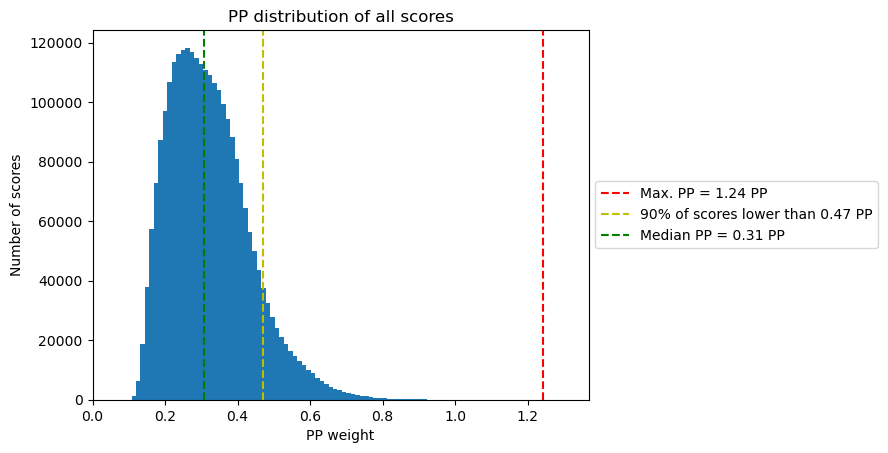

# 2 - Map PP statistics

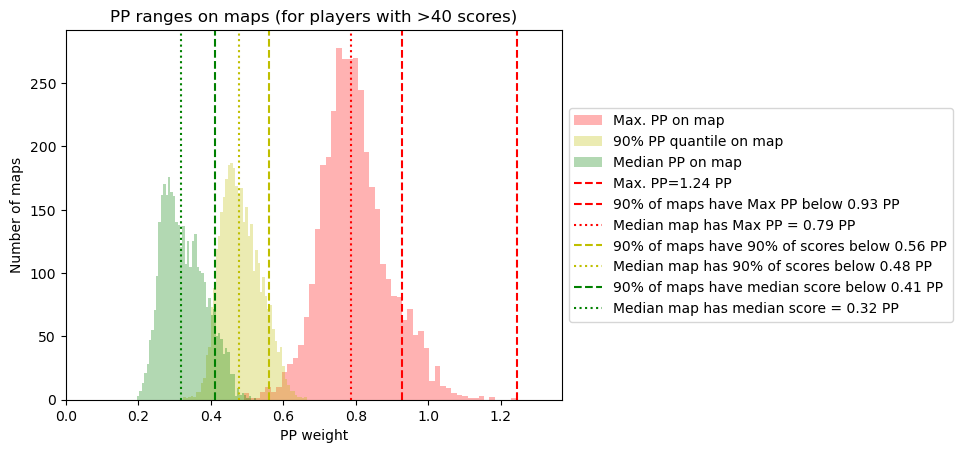

# 3 - PP compared with top PP on map, statistics per map

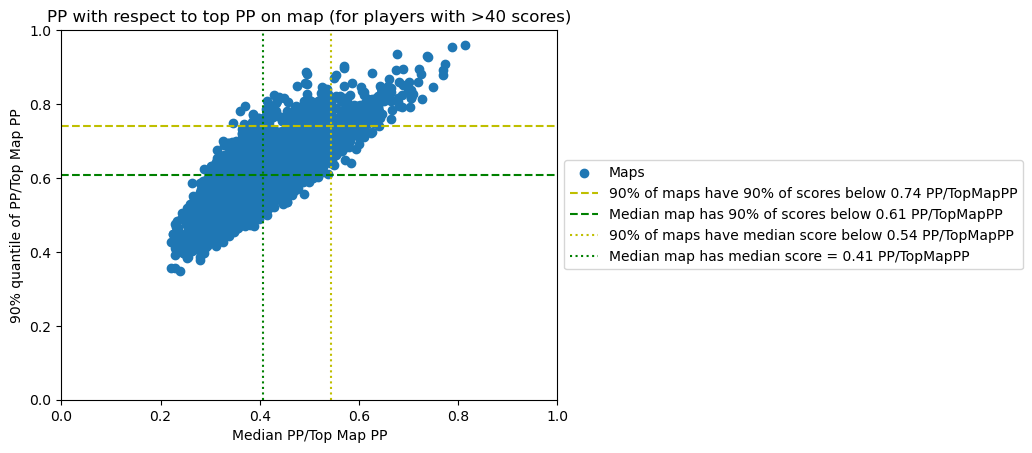

# 4 - PP compared with top PP from player, statistics per map

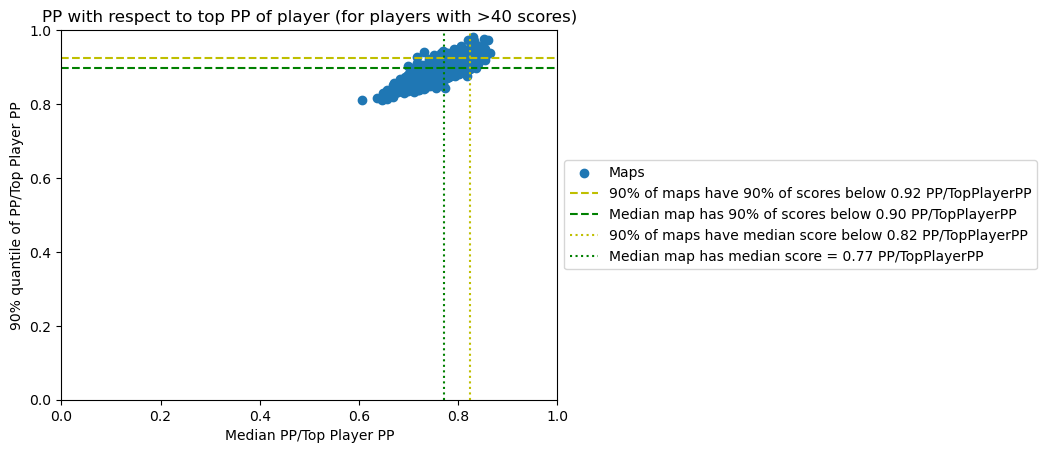

# 5 - PP compared with top PP from player, statistics per player

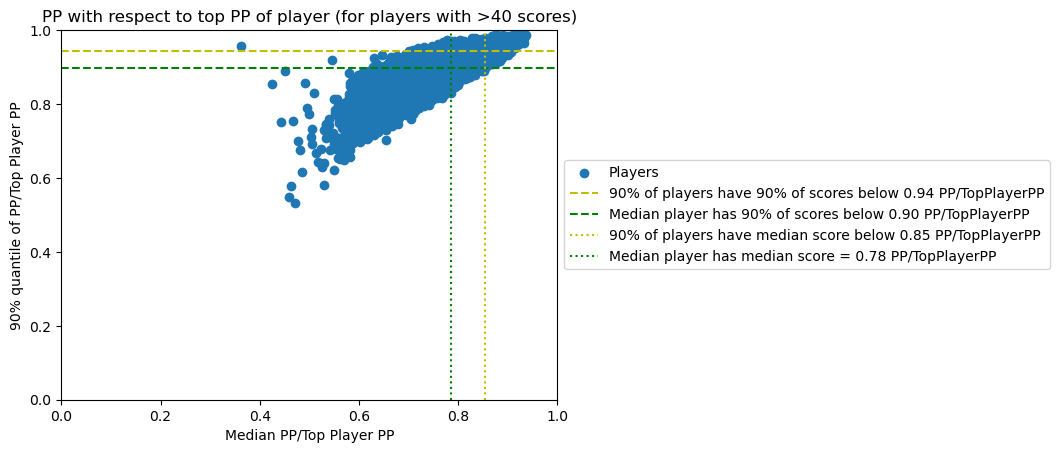

In [218]:
def show_all_global_stats(examples = True):
    reset_sections()
    
    display(Markdown(mdsection("Global score stats")))
    show_global_pp_histogram()
    if examples:
        show_global_pp_top()
        
    display(Markdown(mdsection("Map PP statistics")))
    show_maps_by_pp()
    if examples:
        show_top_max_pp_maps()
        show_top_ninety_pp_maps()
        show_top_median_pp_maps()
        show_bottom_max_pp_maps()
        show_bottom_ninety_pp_maps()
        show_bottom_median_pp_maps()

    display(Markdown(mdsection("PP compared with top PP on map, statistics per map")))
    show_maps_by_pp_div_top_map_pp()
    if examples:
        show_top_ninety_pp_div_top_map_pp_maps()
        show_top_median_pp_div_top_map_pp_maps()
        show_bottom_ninety_pp_div_top_map_pp_maps()
        show_bottom_median_pp_div_top_map_pp_maps()

    display(Markdown(mdsection("PP compared with top PP from player, statistics per map")))
    show_maps_by_pp_div_top_player_pp()
    if examples:
        show_top_ninety_pp_div_top_player_pp_maps()
        show_top_median_pp_div_top_player_pp_maps()
        show_bottom_ninety_pp_div_top_player_pp_maps()
        show_bottom_median_pp_div_top_player_pp_maps()

    display(Markdown(mdsection("PP compared with top PP from player, statistics per player")))
    show_players_by_pp_div_top_player_pp()
    if examples:
        show_top_ninety_pp_div_top_player_pp_players()
        show_top_median_pp_div_top_player_pp_players()
        show_bottom_ninety_pp_div_top_player_pp_players()
        show_bottom_median_pp_div_top_player_pp_players()

show_all_global_stats(False)

## Exporting results

### For beta fits

In [ ]:
for map_id, (a,b,max_score_mult) in result_map_params.items():
    maps_by_id[map_id]["BetaAlpha"] = a
    maps_by_id[map_id]["BetaBeta"] = b
    maps_by_id[map_id]["MaxScoreMult"] = max_score_mult    

for player_id, (player_skill,weight) in result_player_skills.items():
    players_by_id[player_id]["skill"] = player_skill.tolist()

In [ ]:
for score in filtered_scores:
    map_id = score["LeaderboardId"]
    accuracy = score["Accuracy"]
    (a,b,max_score_mult) = result_map_params[map_id]
    score_skill = beta.cdf(rscore(accuracy,max_score_mult=max_score_mult), a, b)
    score["Skill"] = score_skill.tolist()

In [ ]:
current_time = datetime.datetime.now()

current_time_str = current_time.strftime("%Y_%m_%d_%H_%M_%S")

total_dictionary = {
    "Maps":list(maps_by_id.values()),
    "Players":list(players_by_id.values()),
    "Scores":filtered_scores
}

filename = f"beta_trained_data_{current_time_str}.json"

with open(filename, "w") as f:
    json.dump(total_dictionary, f)

#filename_metrics = f"beta_trained_metrics_{current_time_str}.json"

#with open(filename_metrics, "w") as f:
#    json.dump(metrics, f)

### For absolutely monotonic linear interpolation

In [ ]:
for map_id, params in result_map_params.items():
    maps_by_id[map_id]["Multiplier"] = params[0].tolist()
    maps_by_id[map_id]["Nudges"] = params[1:].tolist()

for player_id, (player_skill,weight) in result_player_skills.items():
    players_by_id[player_id]["skill"] = player_skill.tolist()

In [ ]:
#for score in filtered_scores:
    #map_id = score["LeaderboardId"]
    #accuracy = score["Accuracy"]
    #params = result_map_params[map_id]
    # Nothing to add here

In [ ]:
current_time = datetime.datetime.now()

current_time_str = current_time.strftime("%Y_%m_%d_%H_%M_%S")

total_dictionary = {
    "Maps":list(maps_by_id.values()),
    "Players":list(players_by_id.values()),
    "Scores":filtered_scores
}

filename = f"absolutely_monotonic_interp_trained_data_{current_time_str}.json"

with open(filename, "w") as f:
    json.dump(total_dictionary, f)

#filename_metrics = f"beta_trained_metrics_{current_time_str}.json"

#with open(filename_metrics, "w") as f:
#    json.dump(metrics, f)

In [23]:
ranked_data_path = f"absolutely_monotonic_interp_trained_data_2025_06_23_21_48_05.json"
ranked_data_file = open(ranked_data_path,encoding="utf-8")
ranked_data = json.load(ranked_data_file)

In [24]:
players = ranked_data["Players"]
maps = ranked_data["Maps"]
scores = ranked_data["Scores"]

In [25]:
players_by_id = {player["Id"] : player for player in players}
maps_by_id = {bmap["Id"] : bmap for bmap in maps}
print(len(players_by_id.keys()))
print(len(maps_by_id.keys()))

107887
3635


In [26]:
result_map_params = {map_id: [map_data["Multiplier"]] + map_data["Nudges"] for map_id, map_data in maps_by_id.items()}
result_player_skills = {player_id: (player_data.get("skill",0),1) for player_id, player_data in players_by_id.items()}

In [27]:
scores_by_player_id = {}
scores_by_map_id = {}
score_data_by_map_id = {}

def add_score(score):
    player_id = score["PlayerId"]
    map_id = score["LeaderboardId"]
    
    player_map = scores_by_player_id.get(player_id,{})
    player_map[map_id] = score
    
    scores_by_player_id[player_id] = player_map    


    
    map_map = scores_by_map_id.get(map_id,{})
    map_map[player_id] = score
    
    scores_by_map_id[map_id] = map_map   


    
    score_data = score_data_by_map_id.get(map_id,[])

    score_data.append(score["Accuracy"])
    
    # Note that from now on we use the accuracy with respect to gold standard as data.
    # Therefore, when we want to go back to the actual score, we need to multiply by the gold standard or go to the original data.
    #score_data.append(score["accuracy_wrt_gold"])    

    score_data_by_map_id[map_id] = score_data

for score in filtered_scores:
    add_score(score)

for map_id in score_data_by_map_id:
    score_data = score_data_by_map_id[map_id]
    score_data.sort()
    score_data_by_map_id[map_id] = numpy.array(score_data)

## Dirty testing

In [ ]:
current_time = datetime.datetime.now()

current_time_str = current_time.strftime("%Y_%m_%d_%H_%M_%S")

print(current_time_str)

In [ ]:
(a,b) = result_map_params["3e2c2xxxxx91"]
print((a,b))
beta.pdf(1,a,b)

In [ ]:
show_map_density_by_map_id("3e2c2xxxxx91",map_params_by_map_id = result_map_params)

In [51]:
print(sorted_lists["maps_by_max_pp"][:50])

[{'Hash': '2689ee1e1ac4affaf303f87de853fca887bf5d7e', 'Name': 'Shun no shifudo o ikashita Karefumi Paeria 808 shefu no Twerk to Trap shitate', 'CoverImage': 'https://eu.cdn.beatsaver.com/2689ee1e1ac4affaf303f87de853fca887bf5d7e.jpg', 'Mapper': 'ComplexFrequency & miitchel', 'Id': '1329211', 'SongId': '13292', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 5.312314, 'PassRating': 1.3914721, 'TechRating': 1.4478526, 'PredictedAcc': 0.9888375, 'ModifiersRating': {'Id': 6396, 'SSPredictedAcc': 0.9896401, 'SSPassRating': 1.0682442, 'SSAccRating': 5.0144944, 'SSTechRating': 1.1692642, 'SSStars': 2.8193376, 'FSPredictedAcc': 0.9875911, 'FSPassRating': 1.8529507, 'FSAccRating': 5.825613, 'FSTechRating': 1.7965865, 'FSStars': 3.6581862, 'SFPredictedAcc': 0.98566717, 'SFPassRating': 2.5891335, 'SFAccRating': 6.5793705, 'SFTechRating': 2.2520943, 'SFStars': 4.4525604, 'BFSPredictedAcc': 0.9884664, 'BFSPassRating': 1.8728517, 'BFSAccRating': 5.273874, 'BFSTechRating': 1.8104416, 'B

In [45]:
print(global_stats)

{}


In [ ]:
print(maps_by_id["3e2c2xxxxx91"])

In [ ]:
print(len(score_data_by_map_id["c32d91"]))

In [ ]:
print(result_binned_distribution_by_map_id["c32d91"])

In [198]:
#print(players_by_id["76561198101078877"])
print(players_by_id["76561198316609304"])
#print(players_by_id["76561199118771413"])

{'Name': 'nox', 'Country': 'US', 'Id': '76561198316609304', 'Avatar': 'https://avatars.akamai.steamstatic.com/8064d62696198ce6fc133c46b8a4328ab2148a4c_full.jpg', 'skill': 0.7108101613286687, 'NScores': 1, 'MaxPP': 0.7679956033649636, 'NinetyPP': 0.7679956033649636, 'MinPP': 0.7679956033649636, 'AvgPP': 0.7679956033649636, 'MedianPP': 0.7679956033649636, 'MaxPPDivTopPP': 0.6174407658543196, 'NinetyPPDivTopPP': 0.6174407658543196, 'AvgPPDivTopPP': 0.6174407658543196, 'MedianPPDivTopPP': 0.6174407658543196, 'MaxPPDivTopPP40': 0.6174407658543196, 'NinetyPPDivTopPP40': 0.6174407658543196, 'AvgPPDivTopPP40': 0.6174407658543196, 'MedianPPDivTopPP40': 0.6174407658543196, 'MaxPPDivTopMapPP': 0.9577190748357132, 'NinetyPPDivTopMapPP': 0.9577190748357132, 'AvgPPDivTopMapPP': 0.9577190748357132, 'MedianPPDivTopMapPP': 0.9577190748357132, 'MaxPPDivTopMapPP40': 0.9577190748357132, 'NinetyPPDivTopMapPP40': 0.9577190748357132, 'AvgPPDivTopMapPP40': 0.9577190748357132, 'MedianPPDivTopMapPP40': 0.957719

In [201]:
print(sorted_lists["players_by_ninety_pp_div_top_player_pp"][-1])

{'Name': 'J4Jackie', 'Country': 'GB', 'Id': '76561199518208461', 'Avatar': 'https://cdn.assets.beatleader.com/76561199518208461R45.png', 'skill': 0.1525792653660006, 'NScores': 93, 'MaxPP': 0.36942645420351816, 'NinetyPP': 0.19655750254124857, 'MinPP': 0.13565799454561553, 'AvgPP': 0.18020807272660888, 'MedianPP': 0.17373316064574046, 'MaxPPDivTopPP': 0.29700554509798377, 'NinetyPPDivTopPP': 0.15802514281557345, 'AvgPPDivTopPP': 0.1448807909185023, 'MedianPPDivTopPP': 0.1396751951357476, 'MaxPPDivTopPP40': 0.29700554509798377, 'NinetyPPDivTopPP40': 0.15802514281557345, 'AvgPPDivTopPP40': 0.1448807909185023, 'MedianPPDivTopPP40': 0.1396751951357476, 'MaxPPDivTopMapPP': 0.48252515287286846, 'NinetyPPDivTopMapPP': 0.2784851865046262, 'AvgPPDivTopMapPP': 0.2280029006593173, 'MedianPPDivTopMapPP': 0.21892623834428676, 'MaxPPDivTopMapPP40': 0.48252515287286846, 'NinetyPPDivTopMapPP40': 0.2784851865046262, 'AvgPPDivTopMapPP40': 0.2280029006593173, 'MedianPPDivTopMapPP40': 0.21892623834428676,

In [212]:
print([score for score in scores_by_player_id["76561199518208461"].values() if score["PPDivTopPlayerPP"] >= 1])

[{'Id': 20108873, 'LeaderboardId': '1442771', 'Accuracy': 0.9196047, 'Modifiers': '', 'PlayerId': '76561199518208461', 'Timepost': 1735332638, 'FC': False, 'FCAcc': 0.934828, 'PP': 0.36942645420351816, 'PlayerSkill': 0.1525792653660006, 'PlayerNScores': 93, 'PPDivTopPP': 0.29700554509798377, 'PPDivTopPP40': 0.29700554509798377, 'PPDivTopMapPP': 0.48252515287286846, 'PPDivTopMapPP40': 0.48252515287286846, 'PPDivTopPlayerPP': 1.0}]


In [ ]:
a = numpy.array(range(1,10))
aggregation_topscores(a)

In [ ]:
print(max(result_player_skills.values()))

In [ ]:
print(least_squares_beta_parameters_per_map["7e8f11"])

In [ ]:
print(list(result_player_skills.items())[-50:])

In [ ]:
print(result_player_skills["76561199118771413"])

In [ ]:
print(least_squares_beta_parameters_per_map["7e8f11"])
print(result_map_params["7e8f11"])

In [ ]:
filtered_scores[25340]

In [ ]:
list(scores_by_map_id["1e0b511"].values())[:20]

In [ ]:
list(scores_by_player_id["76561198101078877"].values())[:20]

In [ ]:
len(score_data_by_map_id["7b3031"])

In [ ]:
a1, b1, loc1, scale1 = beta.fit(score_data_by_map_id["1e0b511"], floc=0, fscale=1)

print(a1,b1,loc1,scale1)

In [ ]:
pp_curve_integral(0.995,(19.43,1.95,0,1))

In [ ]:
xx = numpy.linspace(min_score,1,50)
print(plot_pp_curve_integral(xx,(20.02,2.795)))

In [ ]:
least_squares_beta_parameters_per_map["3e2c2xxxxx91"]

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["36bce91"]
gold_standard = maps_by_id["36bce91"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["2cf6391"]
gold_standard = maps_by_id["2cf6391"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["7e8f11"]
gold_standard = maps_by_id["7e8f11"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["2a57111"]
gold_standard = maps_by_id["2a57111"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
(a,b) = least_squares_beta_parameters_per_map["3898fx91"]
gold_standard = maps_by_id["3898fx91"]["gold_standard"]
#pass_threshold = 0
params = (a,b,gold_standard)
#params = (a,b,pass_threshold)
for x in [0.7,0.8,0.85,0.9,0.92,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999,1]:
    print(f"{x} - {pp_curve_integral(x,params)}")

In [ ]:
show_map_density_by_map_id("36bce91")

In [ ]:
show_map_distribution_by_map_id("36bce91")

In [ ]:
show_map_pp_by_map_id("36bce91")

In [ ]:
residuals(beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"])

In [ ]:
show_map_distribution_by_map_id("1695b31")

In [ ]:
random_map_summary()

In [ ]:
fit_scores_beta_least_squares(score_data_by_map_id["1695b31"],beta_parameters_per_map["1695b31"])

In [ ]:
r_squared_beta(least_squares_beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"])

In [ ]:
quantiles_beta(least_squares_beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"],10)

In [ ]:
print(best_r_squared_map_id)
print(best_r_squared)

In [ ]:
map_summary("e2ba51")

In [ ]:
a = [1,2,3,4,5]
print(list(zip(a[:-1],a[1:])))

In [ ]:
print(worst_r_squared_map_id)
print(worst_r_squared)

In [ ]:
map_summary("1a56811")

In [ ]:
map_summary("38419x91")

In [ ]:
def testy_test(map_id):
    (a,b) = beta_parameters_per_map[map_id]
    scores = score_data_by_map_id[map_id]
    #scores_with_skills = [(score,0.5) for score in scores]
    #scores_with_skills = [(score,score+random.random()/50) for score in scores]
    #scores_with_skills = [(score,1-2*(1-score)+random.random()/10) for score in scores]
    #scores_with_skills = [(score,0.5+0.5*beta.cdf(score,a,b)) for score in scores]
    scores_with_skills = [(score,0.1+0.6*beta.cdf(score,a,b)+0.3*random.random()) for score in scores]
    print((a,b))
    pass_threshold = 0
    testing_capability = 1
    initial_params = (a,b,pass_threshold,testing_capability)
    
    
    (a,b,pass_threshold,testing_capability) = fit_scores_beta_least_squares_affine_skills(scores_with_skills, initial_params)
    
    print((a,b,pass_threshold,testing_capability))
    show_map_distribution(maps_by_id[map_id], scores, a, b, pass_threshold, testing_capability)
    print(f"r2 = {r_squared_beta_affine_skills((a,b,pass_threshold,testing_capability),scores_with_skills)}")
    #print(residuals_affine_skills((a,b,pass_threshold,testing_capability),scores_with_skills))

map_id = worst_r_squared_map_id
testy_test(map_id)


#golden_standard_map_ids = ["c32d91","2ee3bxxxxxx91","7e8f11","36bce91","1f6b1xxxxxxxx91","23596xxx91","2cf6391","3e2c2xxxxx91","3bcf5xxxxxxxx91"]

#for map_id in golden_standard_map_ids:
#    testy_test(map_id)

In [ ]:
print(len(maps_by_id.keys()))

In [ ]:
for map_id, (a,b) in least_squares_beta_parameters_per_map.items():
    if a < 1 or b < 1:
        print(f"Map id {map_id} has ({a},{b})")

In [ ]:
a = [1,50,3,150,200,125]
na = numpy.array(a)
cdf = ecdf(na)
print(cdf.cdf.probabilities)
print(cdf.cdf.evaluate(na))

In [ ]:
params = [9.29804422,5,0.99980001]

print(pp_curve_log(1,params))

In [ ]:
a1 = numpy.array([2,4,6])
a2 = numpy.array([2,3,1])

print(a1/a2)

In [ ]:
residual_step = 0.01
kernel_sigma = 0.01

scores = numpy.array([0.91,0.92,0.93,0.94,0.95])
skills = numpy.array([0.25,0.6,0.7,0.8,0.99])
weights = numpy.array([1,1,1,1,3])

x_eval = numpy.arange(0.9,0.96,residual_step)
    
delta_x = x_eval[:, None] - scores
print(delta_x)
kernel_weights = numpy.exp(-delta_x*delta_x / (2*kernel_sigma*kernel_sigma)) / (numpy.sqrt(2*numpy.pi) * kernel_sigma)
kernel_weights *= weights
kernel_weights /= numpy.sum(kernel_weights, axis=1, keepdims=True)   
y_eval = numpy.dot(kernel_weights, skills)
print(x_eval)
print(y_eval)

In [ ]:
list1 = [1,6,2,34,5]
list2 = [2,5,1,2,1]
list3 = [1,2,3,4,5]

(r1, r2, r3) = zip(*sorted(zip(list1, list2, list3)))

print(numpy.array(r1))
print(numpy.array(r2))
print(numpy.array(r3))

In [ ]:
arr1 = numpy.array([1,2,3,4,5])
arr2 = numpy.array([2,5,10,2,1])

print(arr1*arr2)

In [ ]:
print(hyperexponential_coefficient)

In [ ]:
print(pp_from_skill_hyperexponential(numpy.array(0.9999)))

In [ ]:
initial_bin_width = 0.15
bin_width_multiplier = 0.88

bin_width = initial_bin_width
cur_value = 0
for i in range(500):
    print(cur_value)
    cur_value += bin_width
    bin_width *= bin_width_multiplier

In [ ]:
params = result_map_params["c32d91"]
(scores,skills,weights) = result_binned_distribution_by_map_id["c32d91"]

(integral_xx, integral_yy) = generate_integral_plot(params)

model_pp = pp_curve_integral_interp(scores,integral_xx,integral_yy)
empirical_pp = skills

print(f"SCORES: {scores}")
print(f"SKILLS: {skills}")
print(f"MODEL SKILLS: {model_pp}")
print(weights*(model_pp - empirical_pp))

In [ ]:
BEFORE: [0.01423508 0.04949665 0.07025268 0.04991144 0.09434535 0.06119659
 0.0509085  0.06374559 0.04429101 0.07234408 0.11287477 0.08881277
 0.11629418 0.05154203 0.13658004 0.14453326 0.04343091 0.07345516
 0.09387031 0.10718113 0.06231441 0.038017   0.07373663 0.04841483
 0.05369599 0.05406857 0.17945166 0.05469607 0.11254375 0.04781629
 0.02351183 0.06159296 0.0706169  0.02451002 0.0313568  0.05109949
 0.05843703 0.01700447 0.07676207 0.04138538 0.09674453 0.05351349
 0.05702596 0.05060943 0.08411264 0.19979272 0.05028419 0.08656628
 0.09622077 0.03952413 0.09643475 0.10591115 0.11028062 0.14953925
 0.02449203 0.0853409  0.06546669 0.04603865 0.09751649 0.05203036
 0.03511162 0.05617589 0.02684697 0.09848451 0.39315141 0.12390531
 0.07117123 0.04992935 0.05530395 0.0905584  0.09994607 0.04686551
 0.01468543 0.0539194  0.04289449 0.03778386 0.02469519 0.01620078
 0.03767879 0.17336019 0.03907492 0.05894821 0.02113422 0.06943576
 0.05239721 0.06404966 0.05386678 0.02330603 0.01568171 0.03357707
 0.04558468 0.06086382 0.00182498 0.00297439 0.01208021 0.01461539
 0.00992662 0.00458281 0.01222478 0.00203334]
AFTER: [0.01648935 0.05767602 0.08191974 0.0581605  0.11006077 0.07134192
 0.0593251  0.07431925 0.05159566 0.08436256 0.13170374 0.10359854
 0.13569773 0.06006509 0.15939227 0.1686819  0.05059104 0.08566034
 0.10950591 0.12505339 0.07264758 0.04426741 0.0859891  0.05641242
 0.06258098 0.06301617 0.20946774 0.06374911 0.1313171  0.0557133
 0.02732489 0.07180491 0.08234516 0.02849081 0.03648807 0.05954818
 0.06811867 0.01972408 0.08952292 0.04820179 0.11286309 0.06236782
 0.0664705  0.05897578 0.09810863 0.23322675 0.05859589 0.10097456
 0.11225132 0.04602778 0.11250125 0.12357    0.12867369 0.17452905
 0.0284698  0.09954328 0.07632955 0.05363696 0.11376476 0.06063547
 0.04087383 0.06547758 0.03122045 0.11489544 0.45907605 0.14458777
 0.08299264 0.05818142 0.06445913 0.10563749 0.11660259 0.05460276
 0.01701536 0.06284193 0.04996447 0.04399509 0.0287071  0.01878534
 0.04387237 0.2023527  0.04550309 0.06871575 0.02454777 0.08096555
 0.06106397 0.07467441 0.06278048 0.02708452 0.01817905 0.03908143
 0.05310671 0.07095324 0.00199394 0.00333649 0.01397238 0.01693356
 0.01145692 0.00521517 0.01414125 0.00223731]

In [ ]:
l = [1,2]
print(l[-2])

In [ ]:
interpolation_scores = numpy.array([0.25,0.5,0.7,0.8,0.85,0.9,0.93,0.95,0.97,0.98,0.99,1])
#interpolation_ss = numpy.array([2,3,4,5,6,7,8,9,10,11,12,13]).astype(numpy.float32)
#interpolation_ss = numpy.array([1,5,10,10,10,10,10,10,10,10,10,10]).astype(numpy.float32)
#interpolation_ss = numpy.array([10,10,10,10,10,10,10,10,10,10,10,10]).astype(numpy.float32)
interpolation_ss = numpy.array([1,1,1,1,1,1,1,1,1,1,1,1]).astype(numpy.float32)
#interpolation_ss = numpy.array([2,2,2,2,2,2,2,2,2,2,2,2]).astype(numpy.float32)
#interpolation_ss = numpy.array([1,2,3,4,5,6,7,8,9,10,11,12]).astype(numpy.float32)
#interpolation_ss = numpy.array([0.5,7,2,5,1,5,1,10,1,1,1,10]).astype(numpy.float32)
(xx,yy,yyy) = linear_interpolation_from_absolutely_monotonic_direct(interpolation_scores, interpolation_ss)
xx = numpy.array(xx)
yy = numpy.divide(numpy.array(yy),yy[-1])
#yy = numpy.divide(numpy.array(yy),numpy.exp(5.5))

print(xx)
print(yy)
#print((yy[1:]-yy[:-1])/(xx[1:]-xx[:-1]))
print(yyy)
#show_linear_interpolation(xx[6:],yy[6:])
show_linear_interpolation(xx,yy)

xx2 = numpy.arange(0,1+0.01,0.01)
yy2 = numpy.interp(xx2,xx,yy)

#print(xx2,yy2)
#show_linear_interpolation(xx2,yy2)

In [ ]:
print(numpy.exp(300.0))